# Settings

In [ ]:
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/data_loading.R")

library(viridis)
library(tidytext)

Sys.setlocale("LC_TIME", "C")
Sys.setlocale("LC_ALL", "C")

In [2]:
theme_set(theme_gray(base_size = 18))

In [3]:
eval_date = "2021-07-03"

In [4]:
scores <- load_scores(paste0("scores/", eval_date, "_scores.csv"), long_format=TRUE) %>%
  filter(!model %in% c("CU-scenario_high", "CU-scenario_mid", "CU-scenario_low", "CU-nochange", "USC-SI_kJalpha")) %>%
  filter(location != "US")

# Mean WIS

The mean WIS is computed across all states and dates. The gray area shows the baseline performance. 

In [5]:
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) parse(text=gsub(reg, "", x)), ...)
}

In [6]:
options(repr.plot.width=15, repr.plot.height=28, repr.plot.res = 300)

In [7]:
base_df <- subset(scores, model=="COVIDhub-baseline" & score == "wis")  %>% 
  group_by(target)  %>% 
  summarize(mean_wis = mean(value))

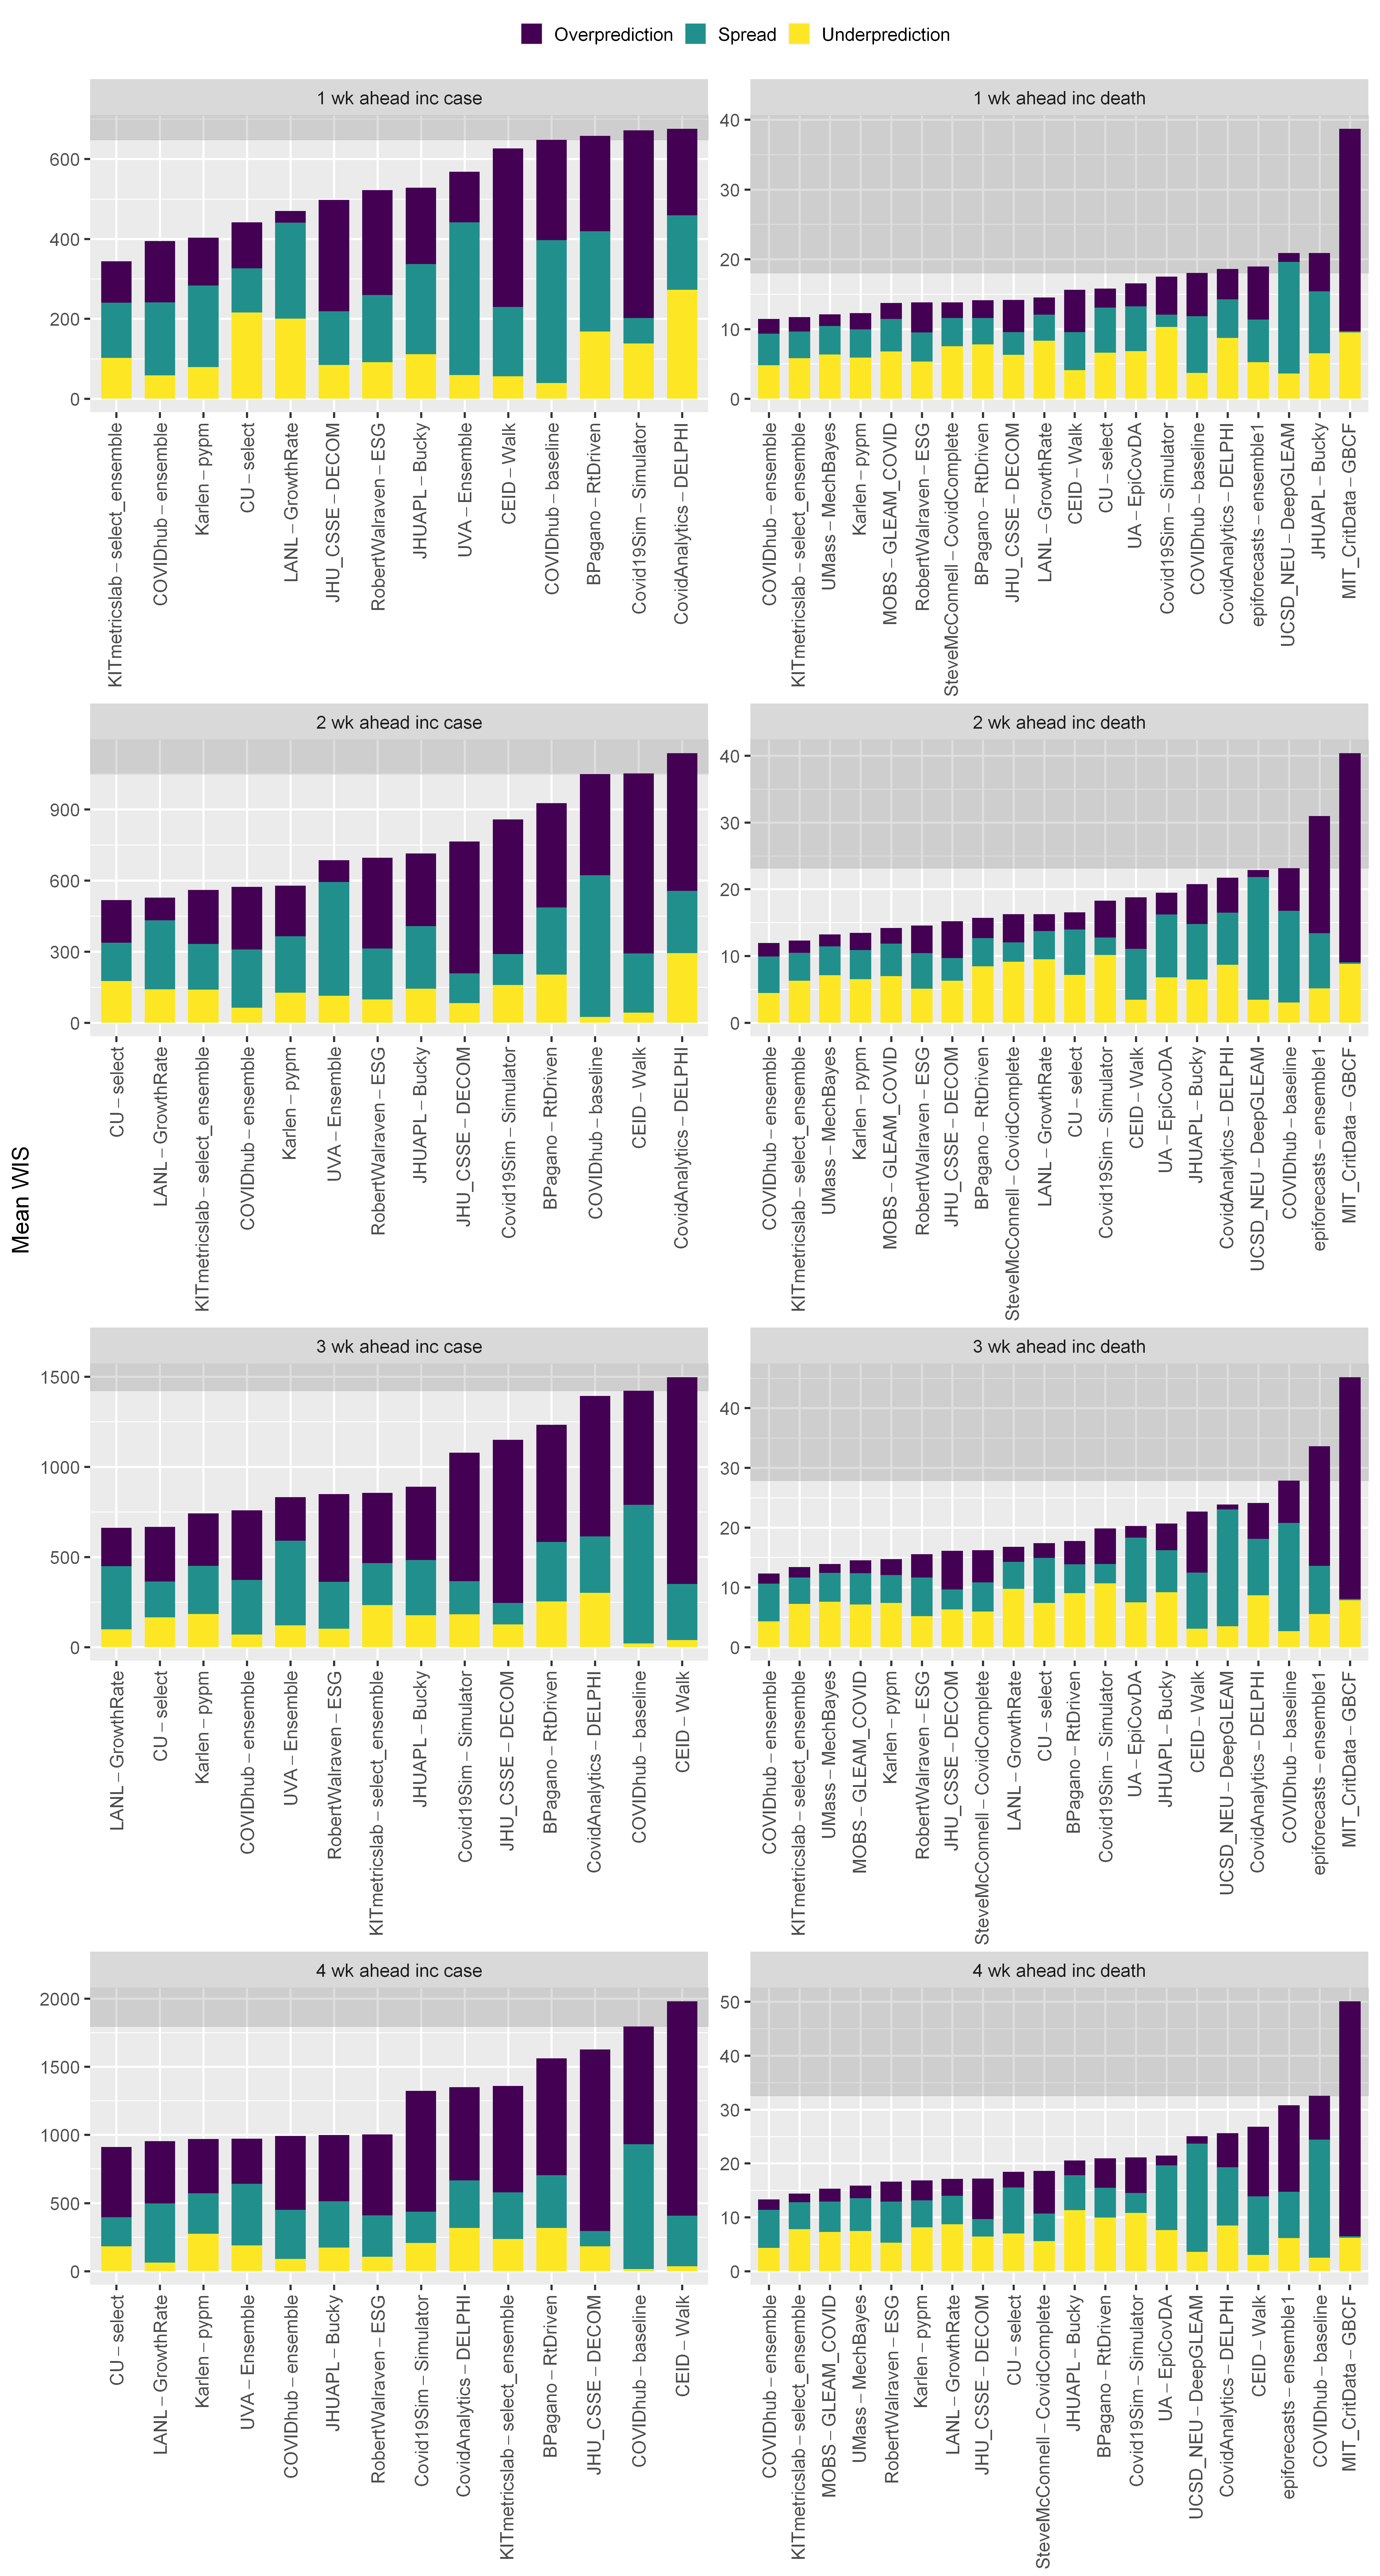

In [8]:
ggplot(subset(scores, score %in% c("wgt_pen_l", "wgt_iw", "wgt_pen_u")), 
       aes(x=reorder_within(model, value, target), y=value,
           fill=factor(score, levels=c("wgt_pen_l", "wgt_iw", "wgt_pen_u")))) +
  geom_rect(data=base_df, 
              aes(xmin=-Inf, xmax=Inf, x=NULL, ymin=mean_wis, ymax=Inf),
             size=0, color="gray", alpha=0.2, inherit.aes = FALSE) +
  geom_bar(position="stack", stat="summary", fun=mean, width=0.7) +
  scale_x_reordered() +
  facet_wrap("target", scales="free", drop=TRUE, ncol=2) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position = "top") +
  scale_fill_viridis(discrete=TRUE, name = NULL,
                     labels = c("Overprediction", "Spread", "Underprediction"))+
  labs(x = NULL,
       y = "Mean WIS")

# Mean WIS over time

The mean WIS is computed at each target end date across all states. The gray area shows the baseline performance. The ensemble methods are highlighted with thicker lines (the greenish thick line is the KITmetricslab-select_ensemble).

In [9]:
wis_by_date <- scores %>%
  filter(score == "wis") %>%
  group_by(target, model, target_end_date) %>%
  summarize(mean_WIS = mean(value))

`summarise()` has grouped output by 'target', 'model'. You can override using the `.groups` argument.



In [10]:
wis_by_date <- wis_by_date %>%
  mutate(highlight = (model=="KITmetricslab-select_ensemble" | model=="COVIDhub-ensemble"))

In [11]:
options(repr.plot.width=15, repr.plot.height=24, repr.plot.res = 300)

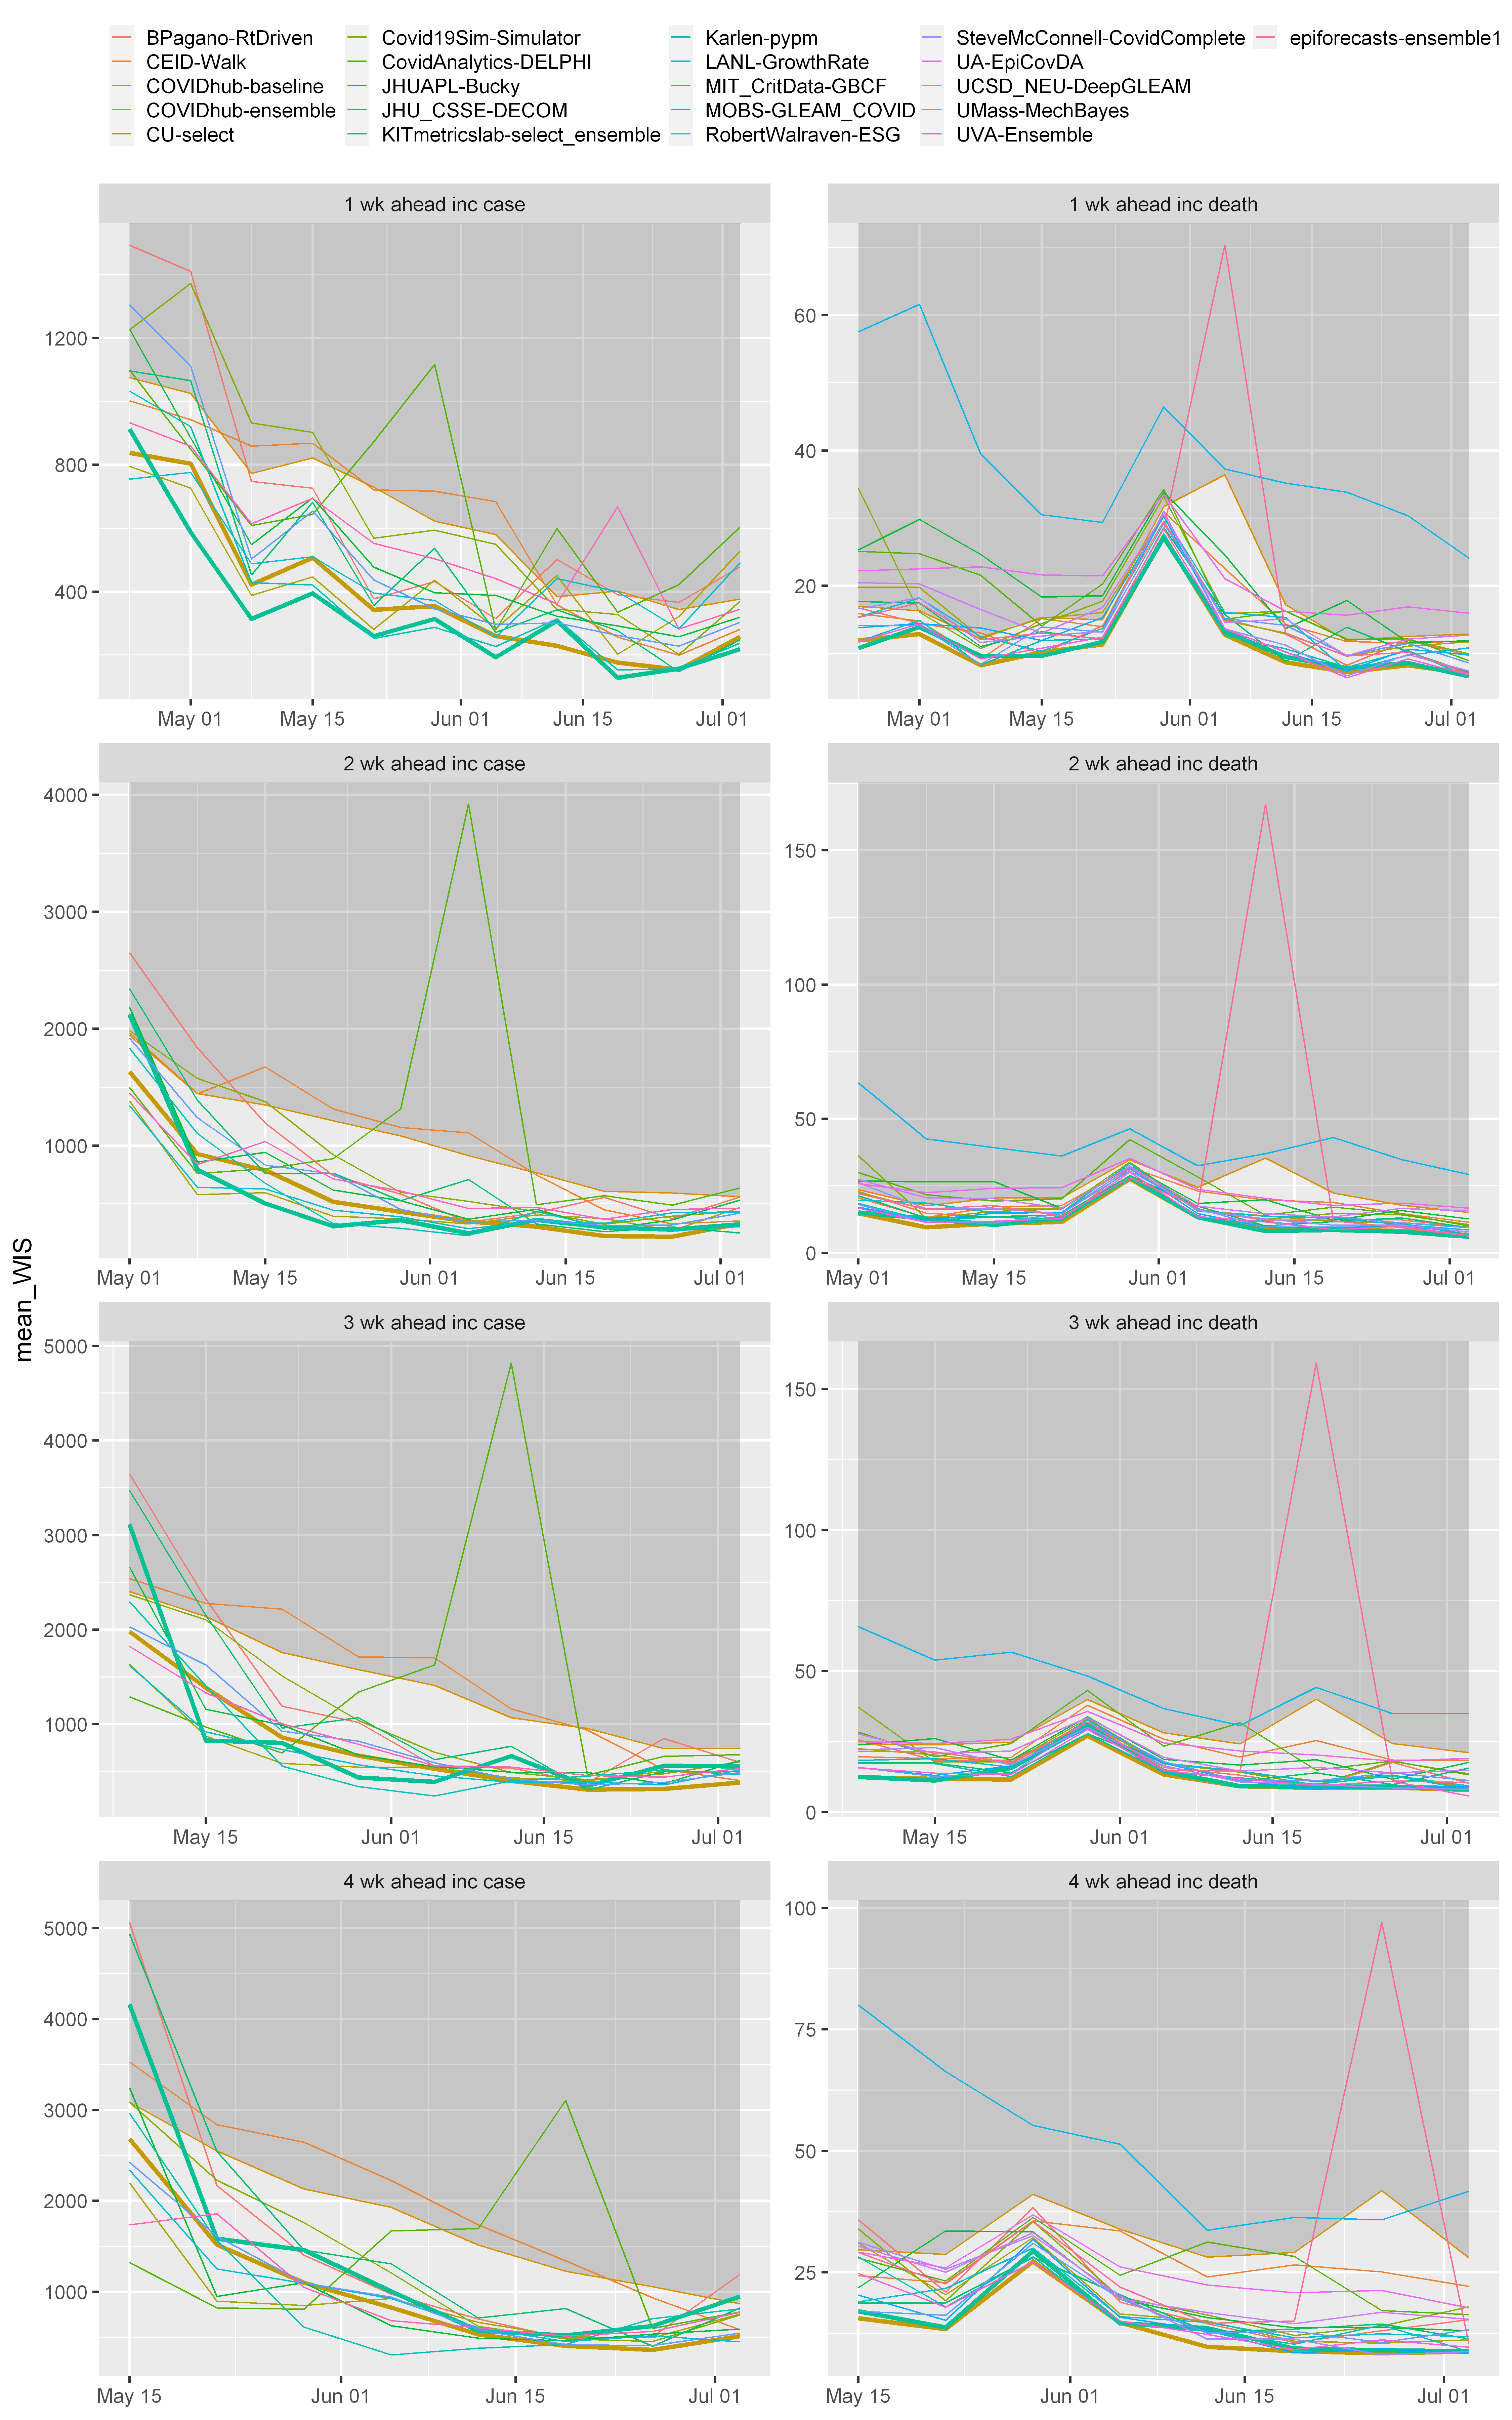

In [12]:
ggplot(wis_by_date, aes(x=target_end_date, y=mean_WIS, group=model)) +
  geom_ribbon(data = subset(wis_by_date,  model == "COVIDhub-baseline"), aes(x=target_end_date, ymin=mean_WIS, ymax=Inf),
             color="gray", alpha=0.2) + 
  geom_line(aes(color=model, size=highlight)) +
  facet_wrap("target", scales="free", ncol=2) +
  scale_size_manual(values = c("TRUE" = 1.5, "FALSE" = 0.5), guide = 'none') +
  xlab(NULL) +
  theme(legend.position = "top", legend.title=element_blank())

# Rank boxplots

The rank is computed for each location (at each date).

In [13]:
df_rank <- scores  %>% 
  filter(score == "wis") %>%
  group_by(target, target_end_date, location, model) %>%
  summarize(meanWIS = mean(value)) %>%
  group_by(target, target_end_date, location) %>%
  arrange(model, meanWIS) %>% 
  mutate(rank=rank(meanWIS)) %>%
  arrange(target_end_date)

df_rank <- df_rank %>%
  group_by(model) %>%
  mutate(meanRank=mean(rank))

`summarise()` has grouped output by 'target', 'target_end_date', 'location'. You can override using the `.groups` argument.



In [14]:
df_rank$type <- "Individual Model"

df_rank[df_rank$model == "KITmetricslab-select_ensemble" |
        df_rank$model == "COVIDhub-ensemble", ]$type <- "Ensemble"

df_rank[df_rank$model == "COVIDhub-baseline", ]$type <- "Baseline"

In [15]:
options(repr.plot.width=16, repr.plot.height=28, repr.plot.res = 300)

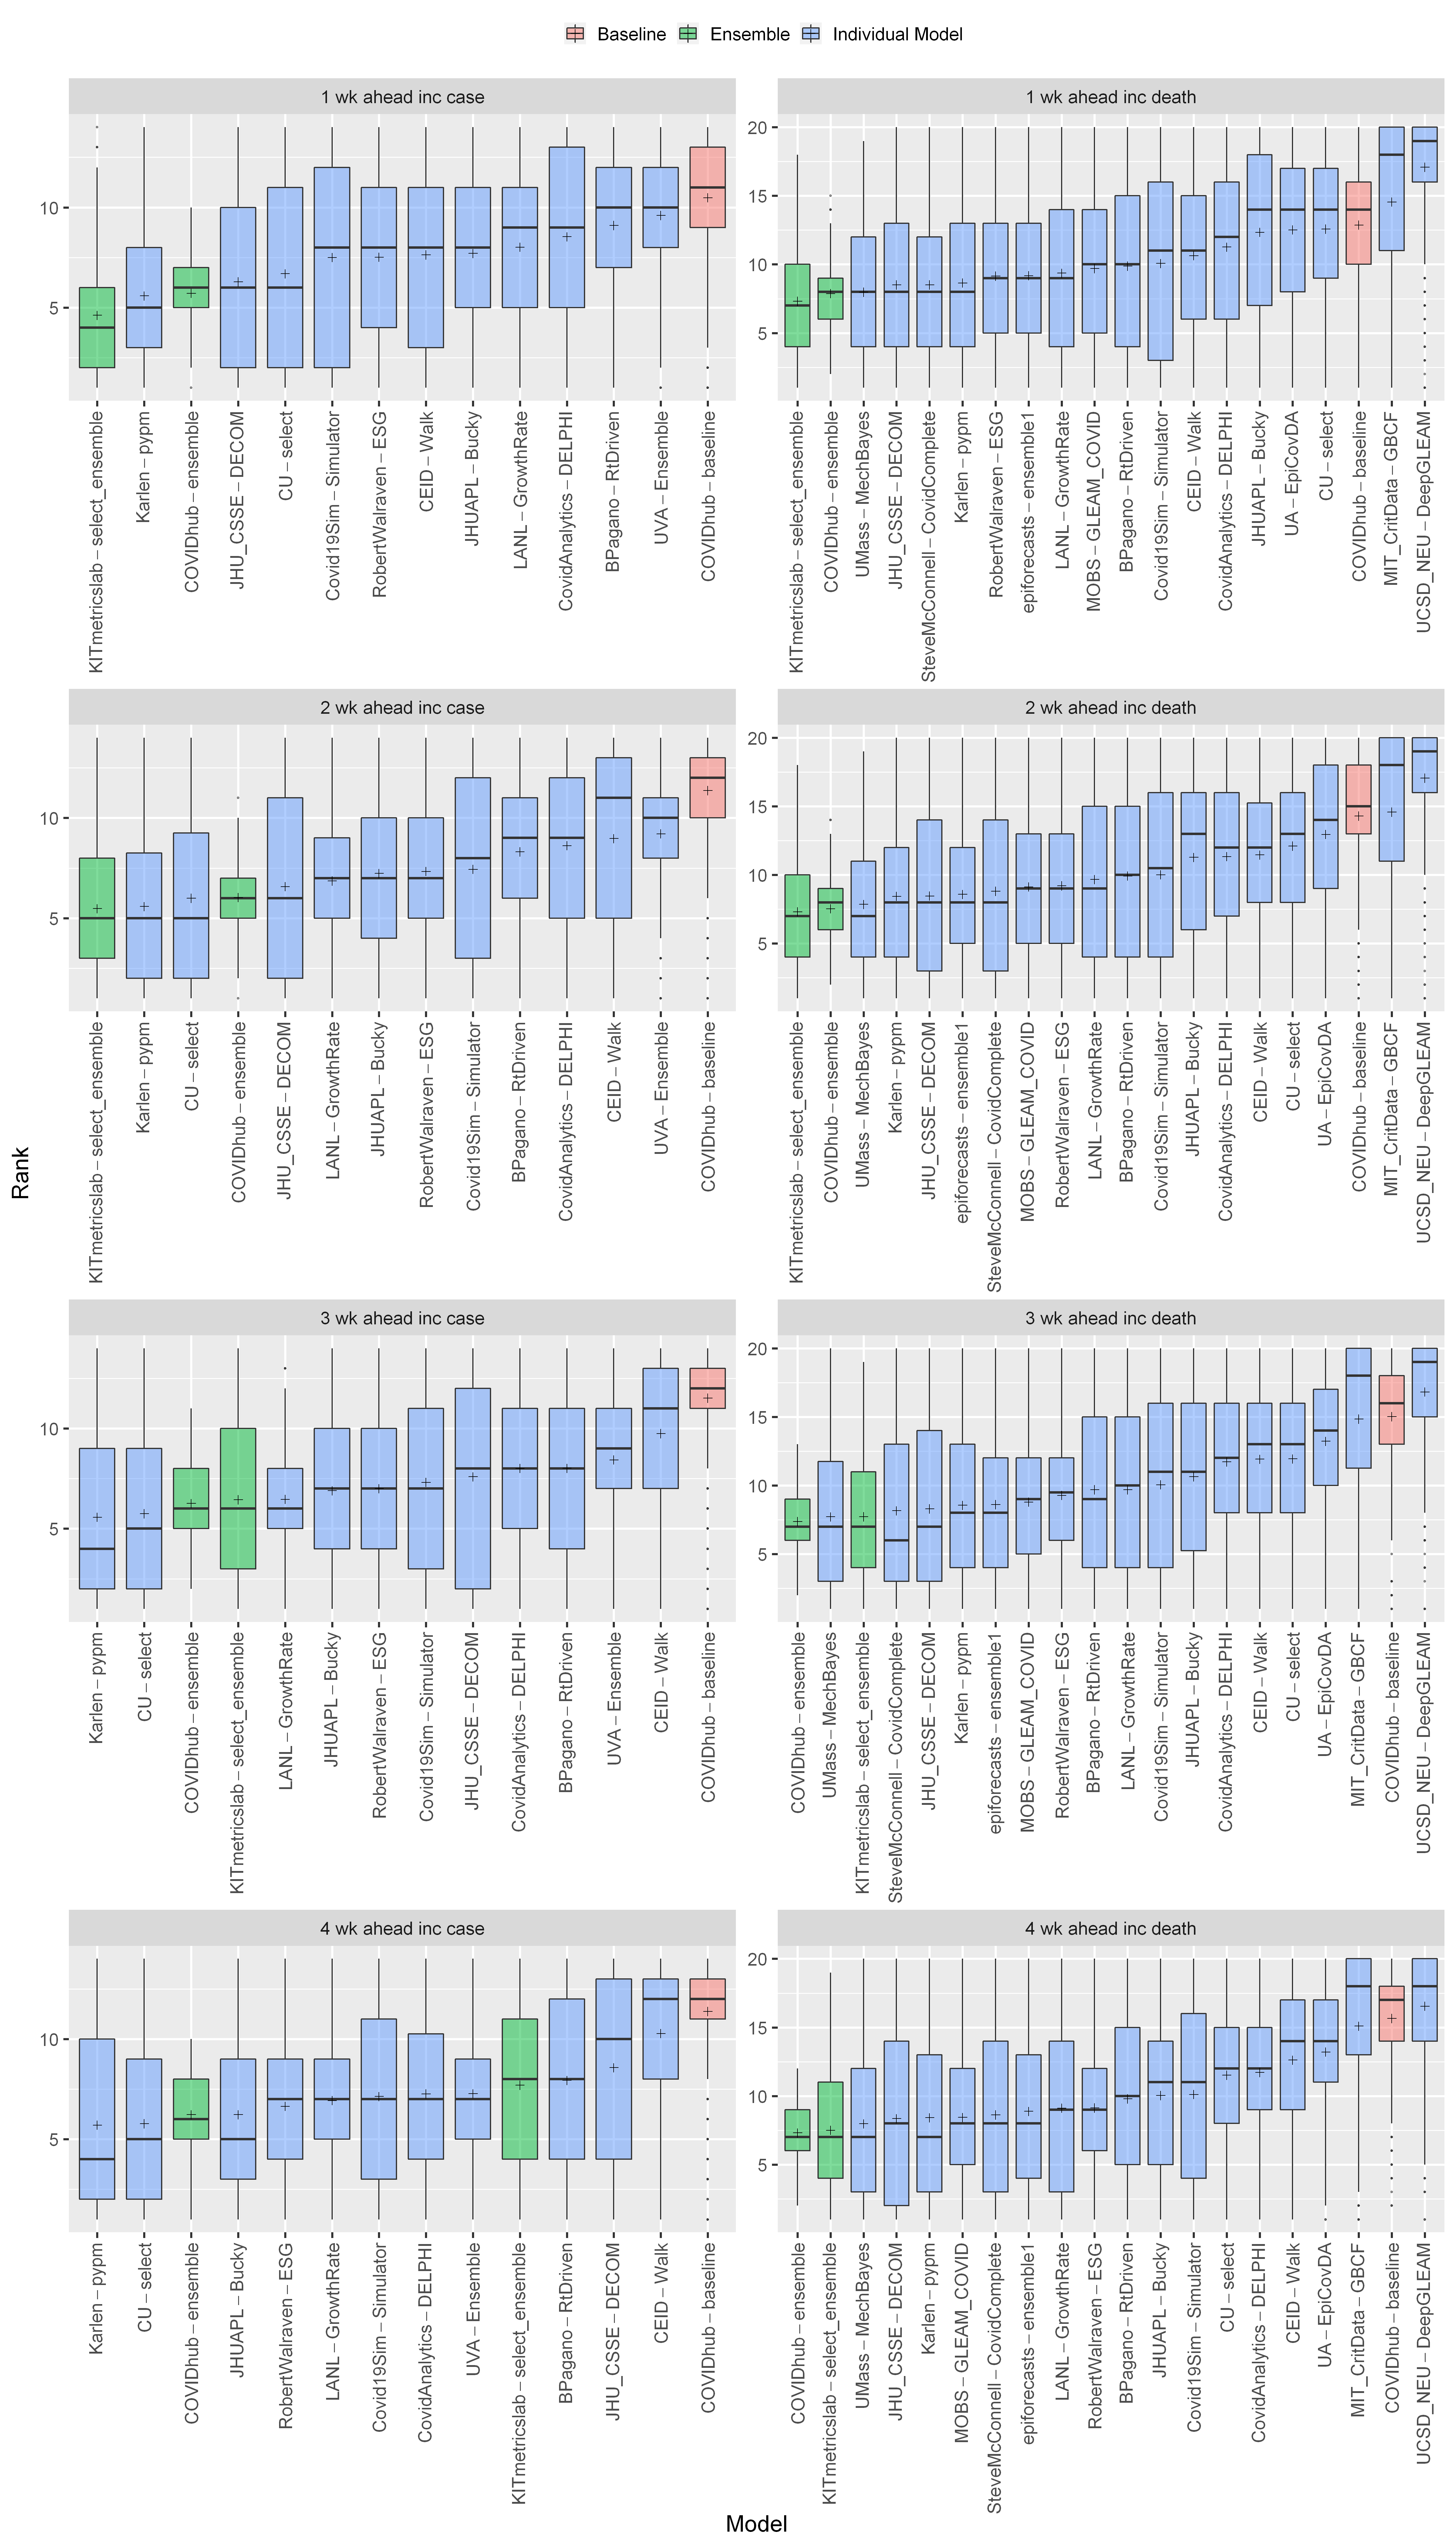

In [16]:
ggplot(df_rank, aes(x=reorder_within(model, rank, target), fill=type, y=rank)) + 
  scale_x_reordered() +
  facet_wrap("target", ncol=2, scales="free") +
  geom_boxplot(alpha=0.5, outlier.size = 0.6) +
  stat_summary(fun=mean, geom="point", shape=3, size=2) +
  xlab("Model") +
  ylab("Rank") +
  theme_gray(base_size=18) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position="top", legend.title=element_blank()) 

# Coverage Plots

In [17]:
df <- read_csv(paste0("evaluation/", eval_date, "_df_processed.csv"), col_types = cols()) %>%
    filter(location != "US")

In [18]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [19]:
plot_coverage <- function(t="death", models=c("KITmetricslab-select_ensemble", "COVIDhub-ensemble", "COVIDhub-baseline")){
    df_temp <- df %>%
    filter(str_detect(target, t) &
          model %in% models)
    df_temp$l <- df_temp$truth < floor(df_temp$value)
    df_temp$u <- df_temp$truth <= floor(df_temp$value)

    df_temp <- df_temp %>%
        group_by(target, model, quantile) %>%
        summarize(l = mean(l), u=mean(u))

    ggplot(df_temp) +
        facet_grid(rows=vars(target), cols=vars(model)) +
        geom_segment(aes(x=0,xend=1,y=0,yend=1), linetype="dashed", colour="grey70")+
        geom_errorbar(aes(x=quantile, ymin=l, ymax=u), width=0.05, size=0.5,
                      data=df_temp, colour="black") +
        scale_x_continuous(breaks = c(0, 0.25, 0.5, 0.75, 1),
                           labels = function(x) ifelse(x == 0, "0", x)) +
        scale_y_continuous(labels = function(y) ifelse(y == 0, "0", y)) +
        xlab('Quantile') +
        ylab('') +
        labs(title=paste0(str_to_title(t), "s"))
}

`summarise()` has grouped output by 'target', 'model'. You can override using the `.groups` argument.



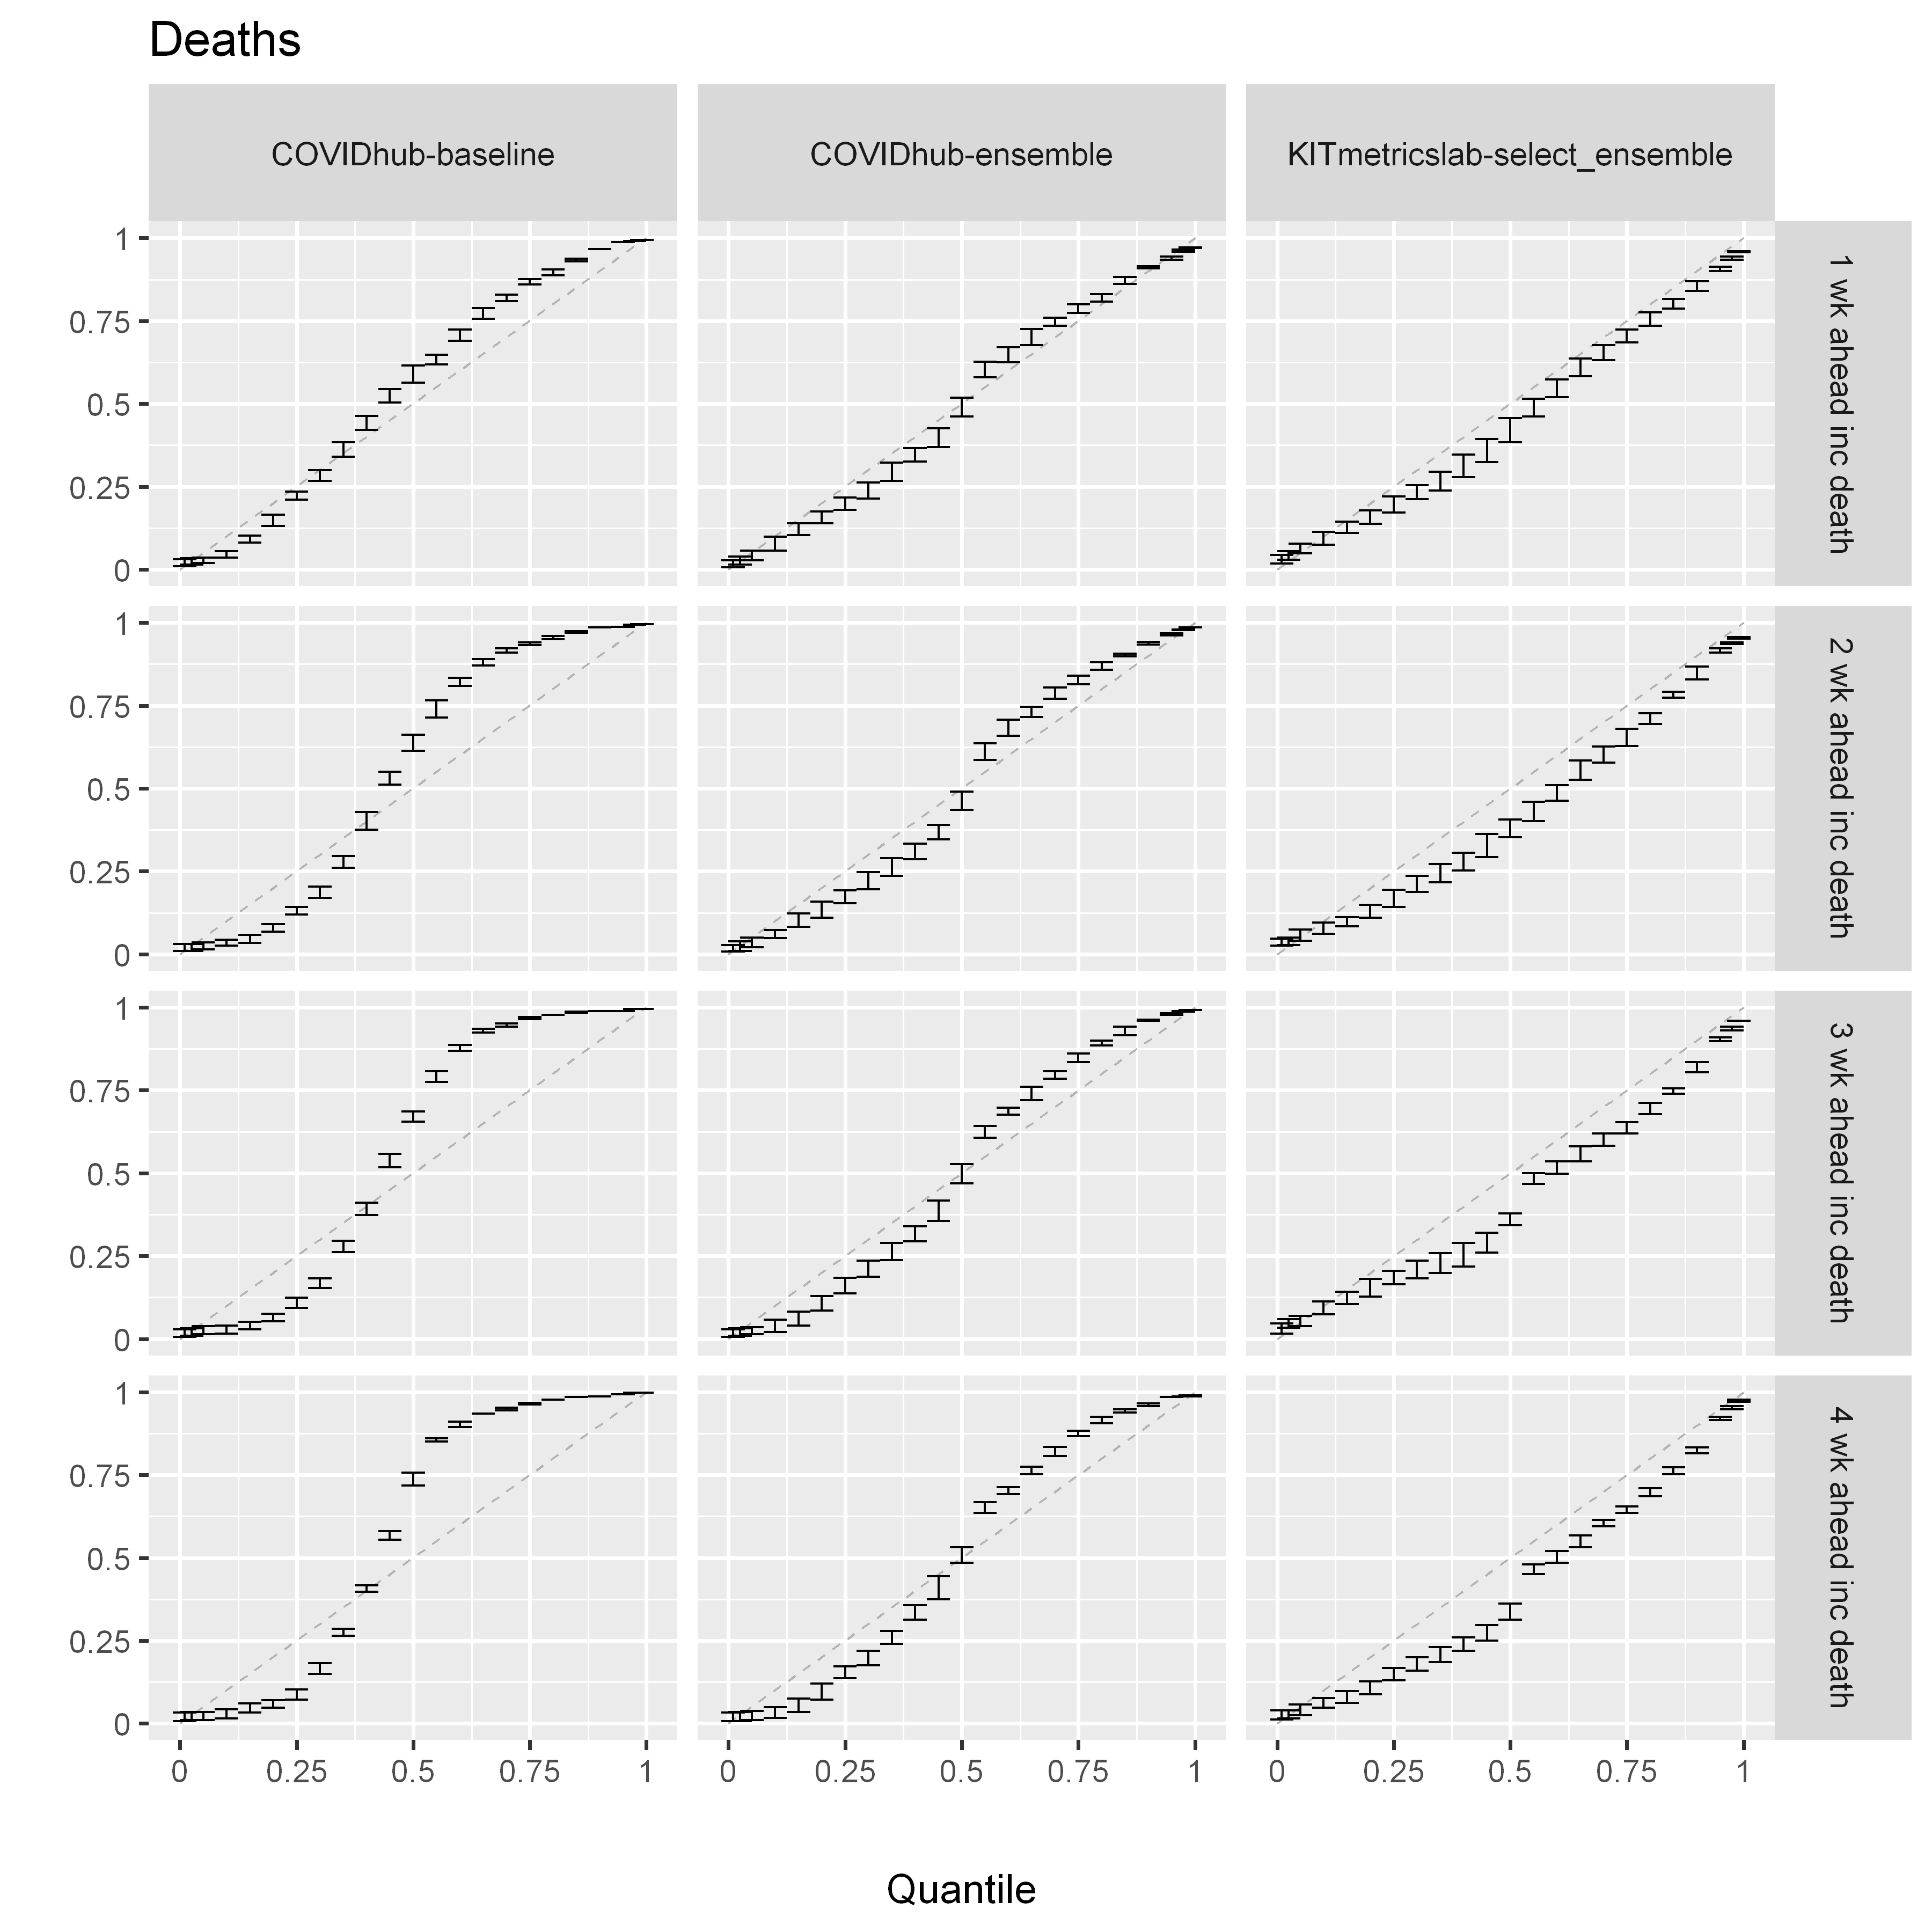

In [20]:
plot_coverage("death")

`summarise()` has grouped output by 'target', 'model'. You can override using the `.groups` argument.



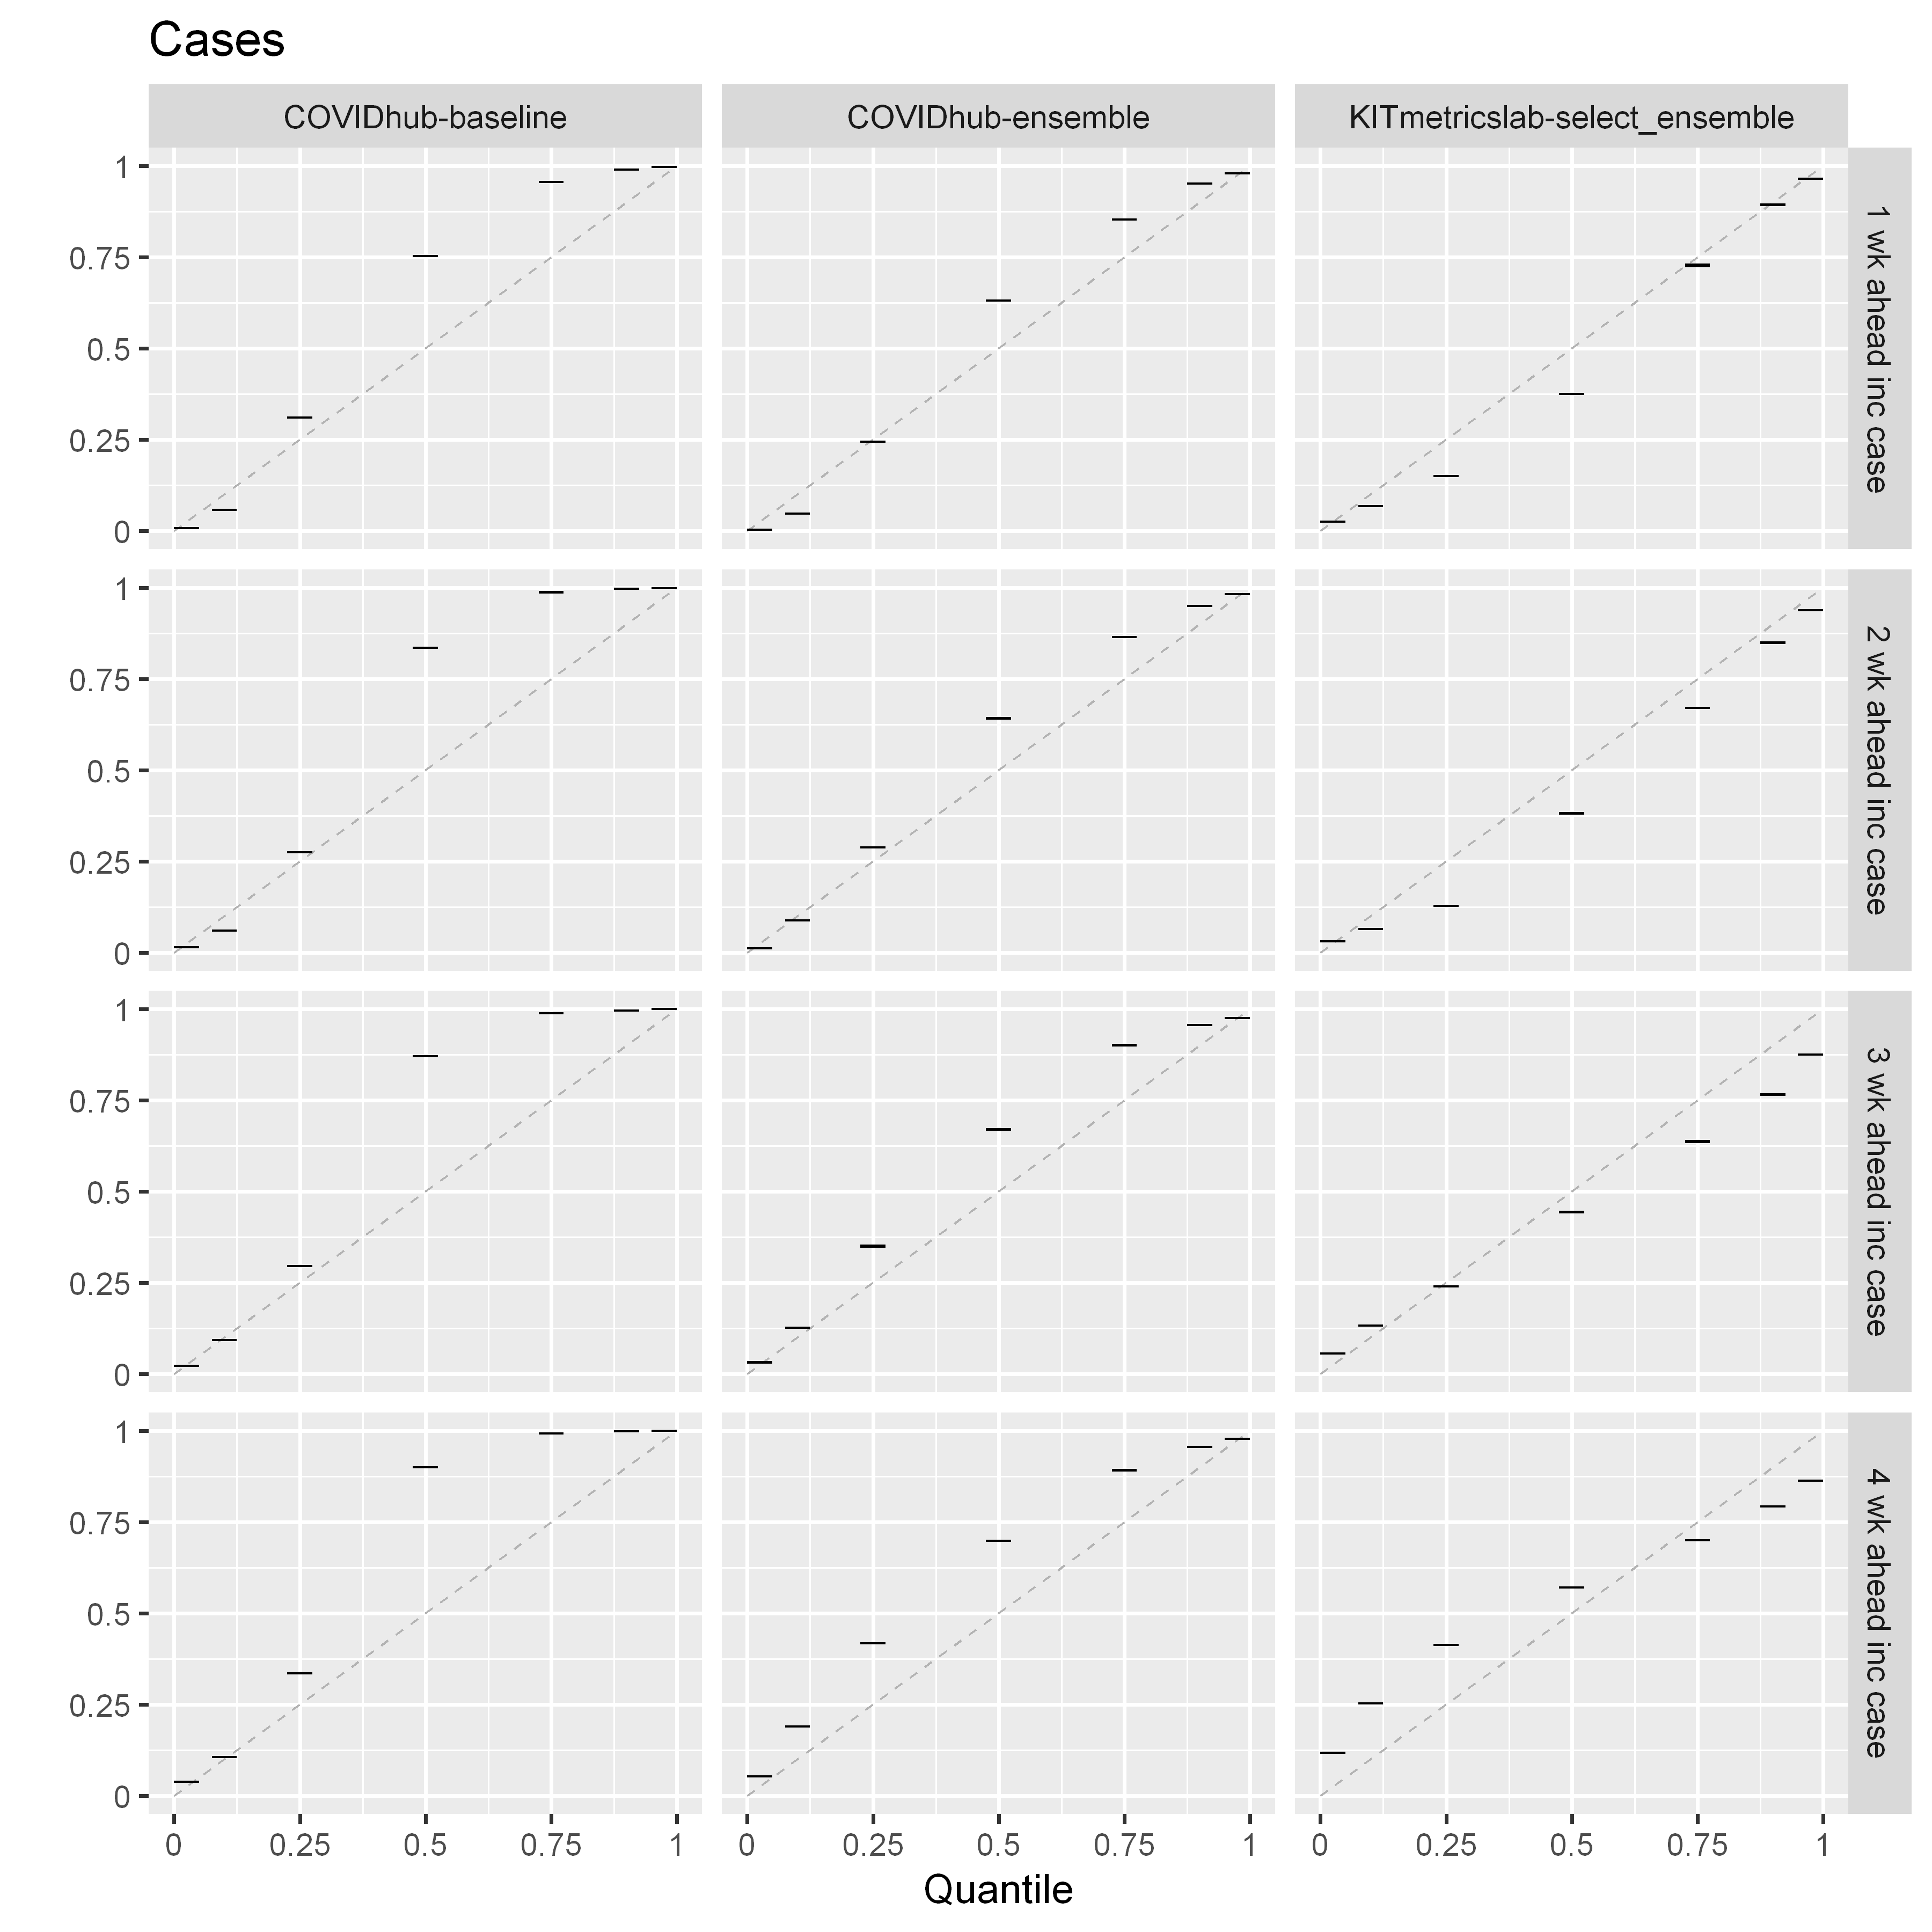

In [21]:
plot_coverage("case")

# Murphy Diagrams

In [22]:
elementary_quantile_score <- function(y_true, y_pred, theta, alpha){
    ((y_true < y_pred) - alpha) * ((theta < y_pred) - (theta < y_true))
}

In [23]:
get_thetas <- function(df, n=1001){
  tmp <- c(df$value, df$truth)
  thetas <- seq(from = min(tmp) - 1, to = max(tmp) + 1, length.out = n)
  return(thetas)
}

In [24]:
df <- read.csv(paste0("evaluation/", eval_date, "_df_processed.csv")) %>%
    filter(location != "US")

In [25]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [26]:
murphy_diagram_by_quantile <- function(df, model1, model2, target, 
                                      quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975, 0.01, 0.05, 0.15, 0.2, 
                                                    0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.95, 0.99)){
    df <- df %>%
      filter((model == model1 | model == model2) & target == !!target & quantile %in% quantiles)
    df <- df %>% left_join(df %>%
                           group_by(quantile) %>%
                           do(crossing(theta = get_thetas(.))), by = "quantile")

    df <- df %>%
      mutate(score = elementary_quantile_score(truth, value, theta, quantile))

    df <- df %>%
      group_by(model, quantile, theta) %>%
      summarize(mean_score = mean(score), .groups="keep")
    
    if(length(quantiles) < 10){
        options(repr.plot.width=12, repr.plot.height=4*ceiling(length(quantiles)/3), repr.plot.res = 300)
    }

    ggplot(df, aes(x=theta, y=mean_score, color=model)) +
      geom_line() +
      facet_wrap("quantile", scales="free") +
      labs(title = paste("Murphy diagrams for each quantile:", target), color = "Model") +
      xlab(expression(paste("Parameter ", theta))) +
      ylab(NULL) +
      theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1, size=10), 
            legend.position="top", legend.justification='left', legend.title=element_blank()) 
}

### Comparision with baseline

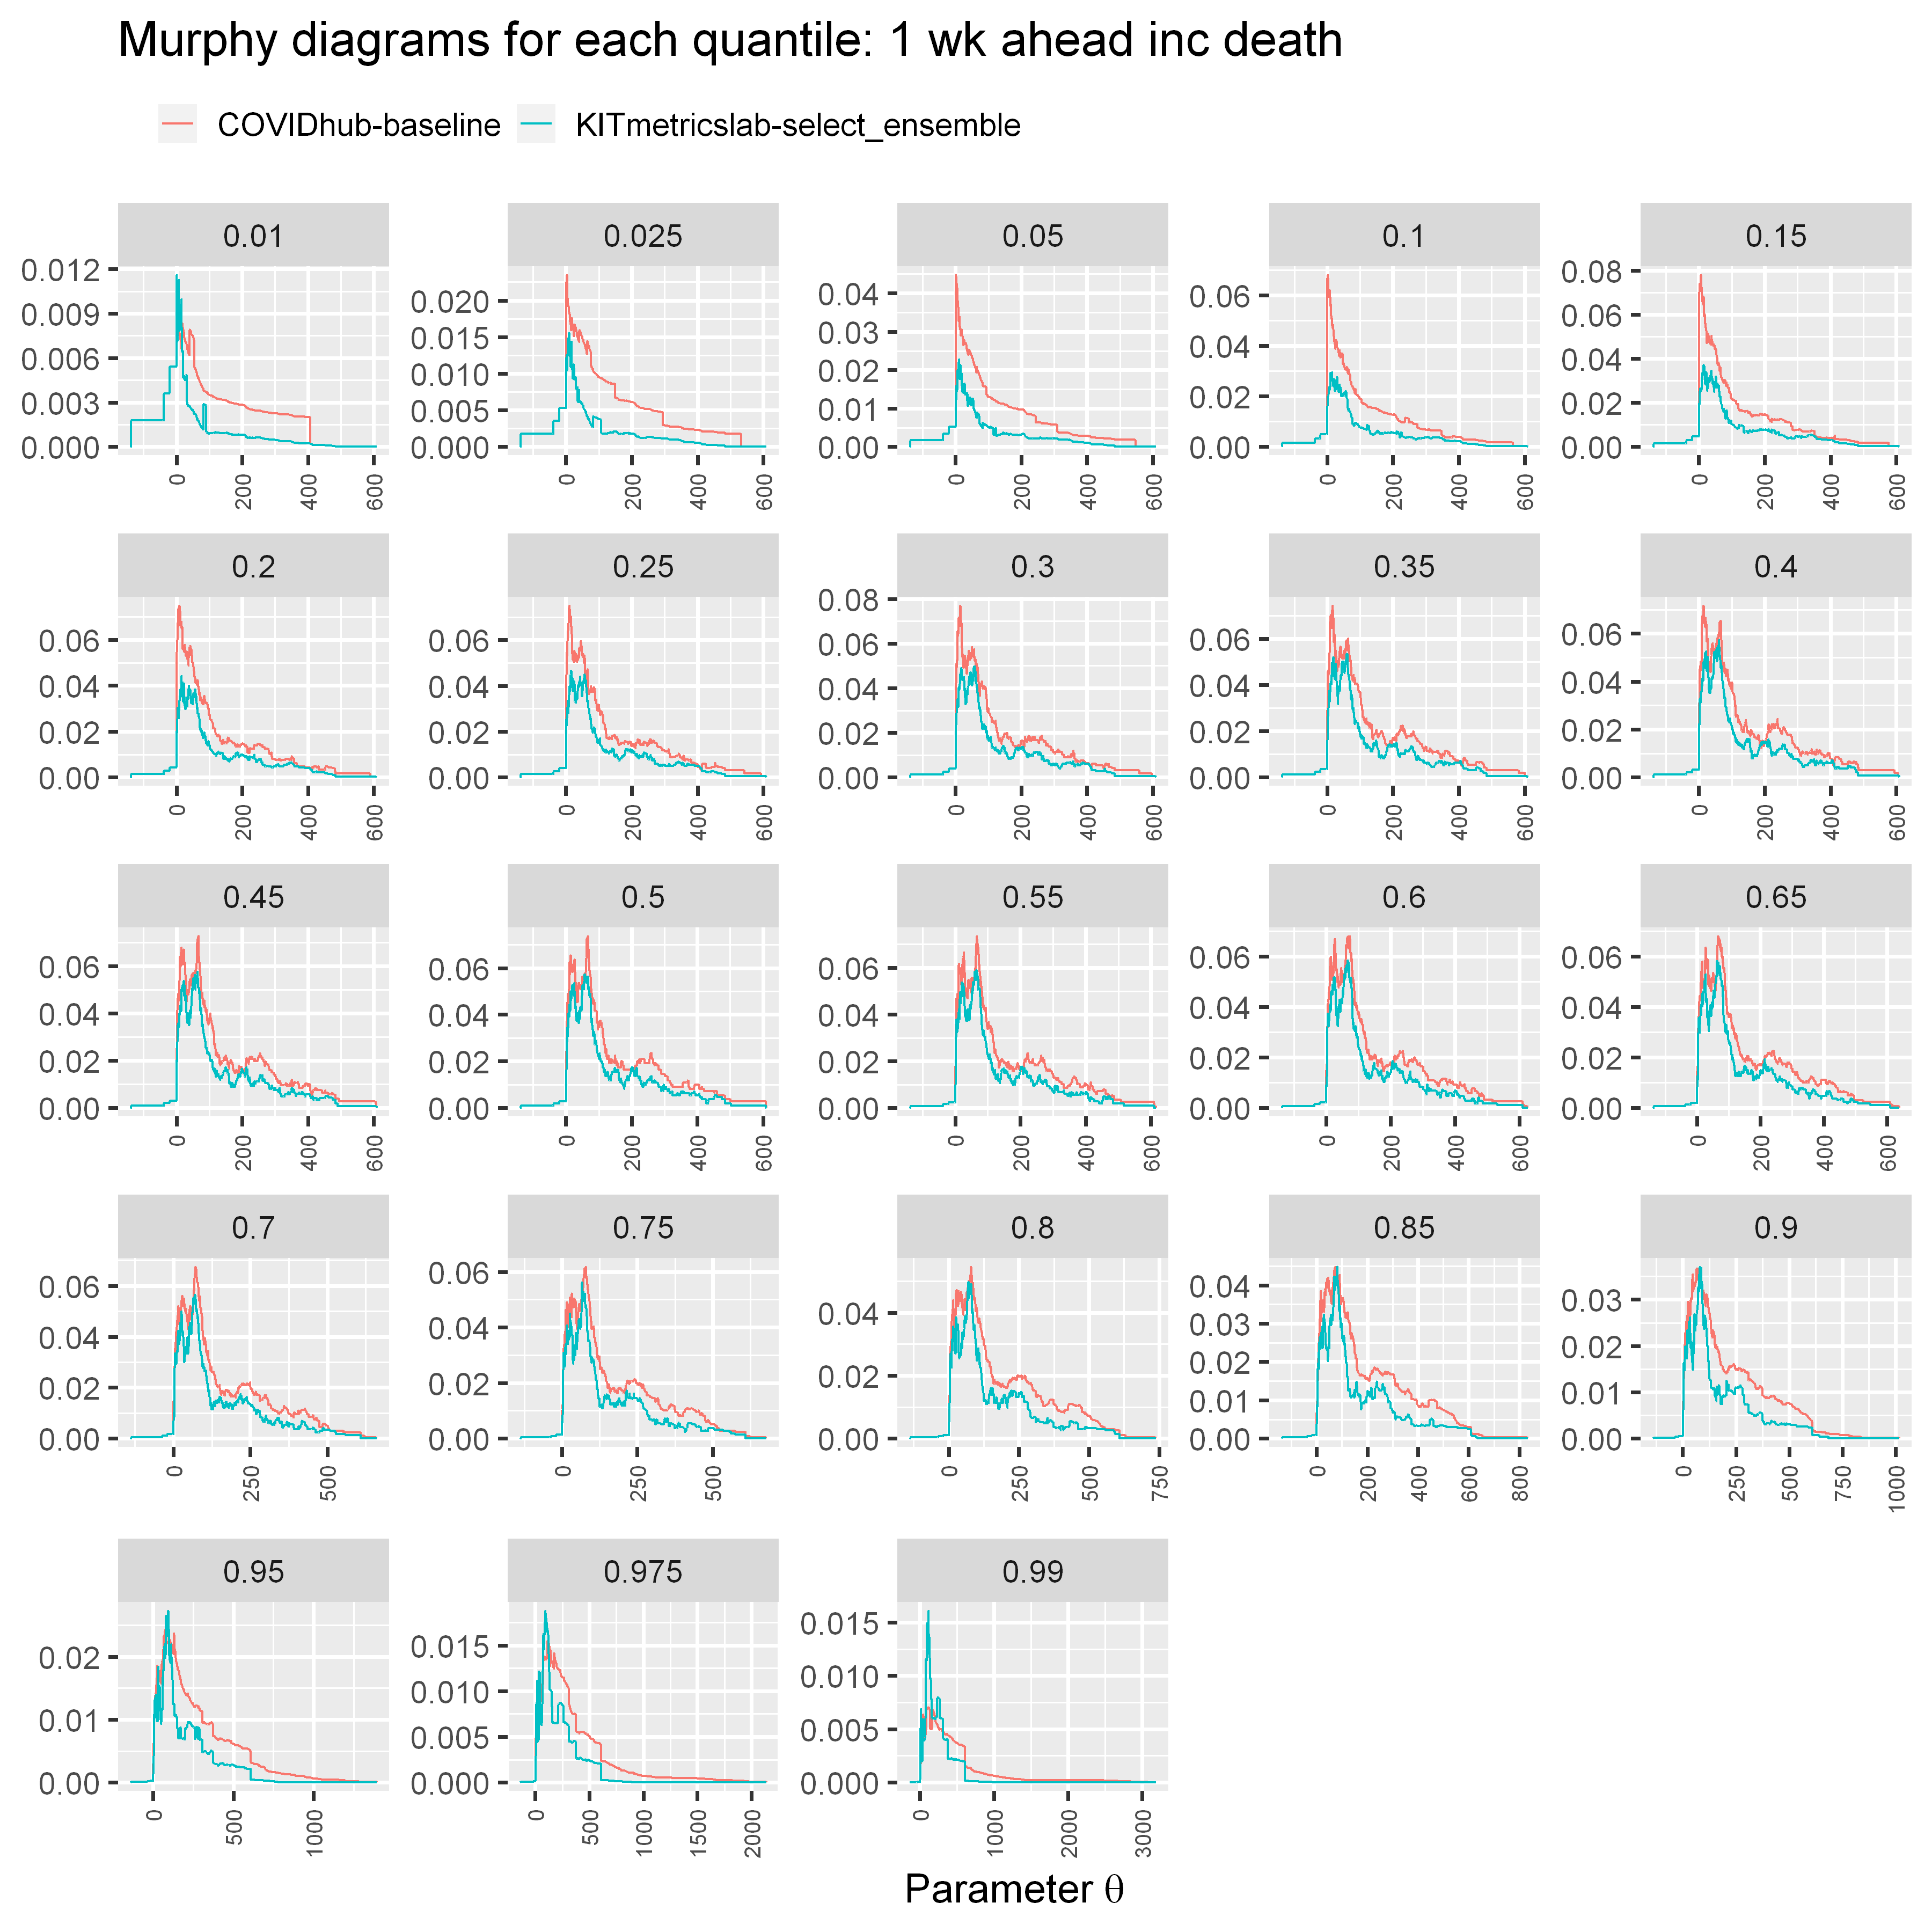

In [27]:
murphy_diagram_by_quantile(df, "KITmetricslab-select_ensemble", "COVIDhub-baseline", "1 wk ahead inc death")

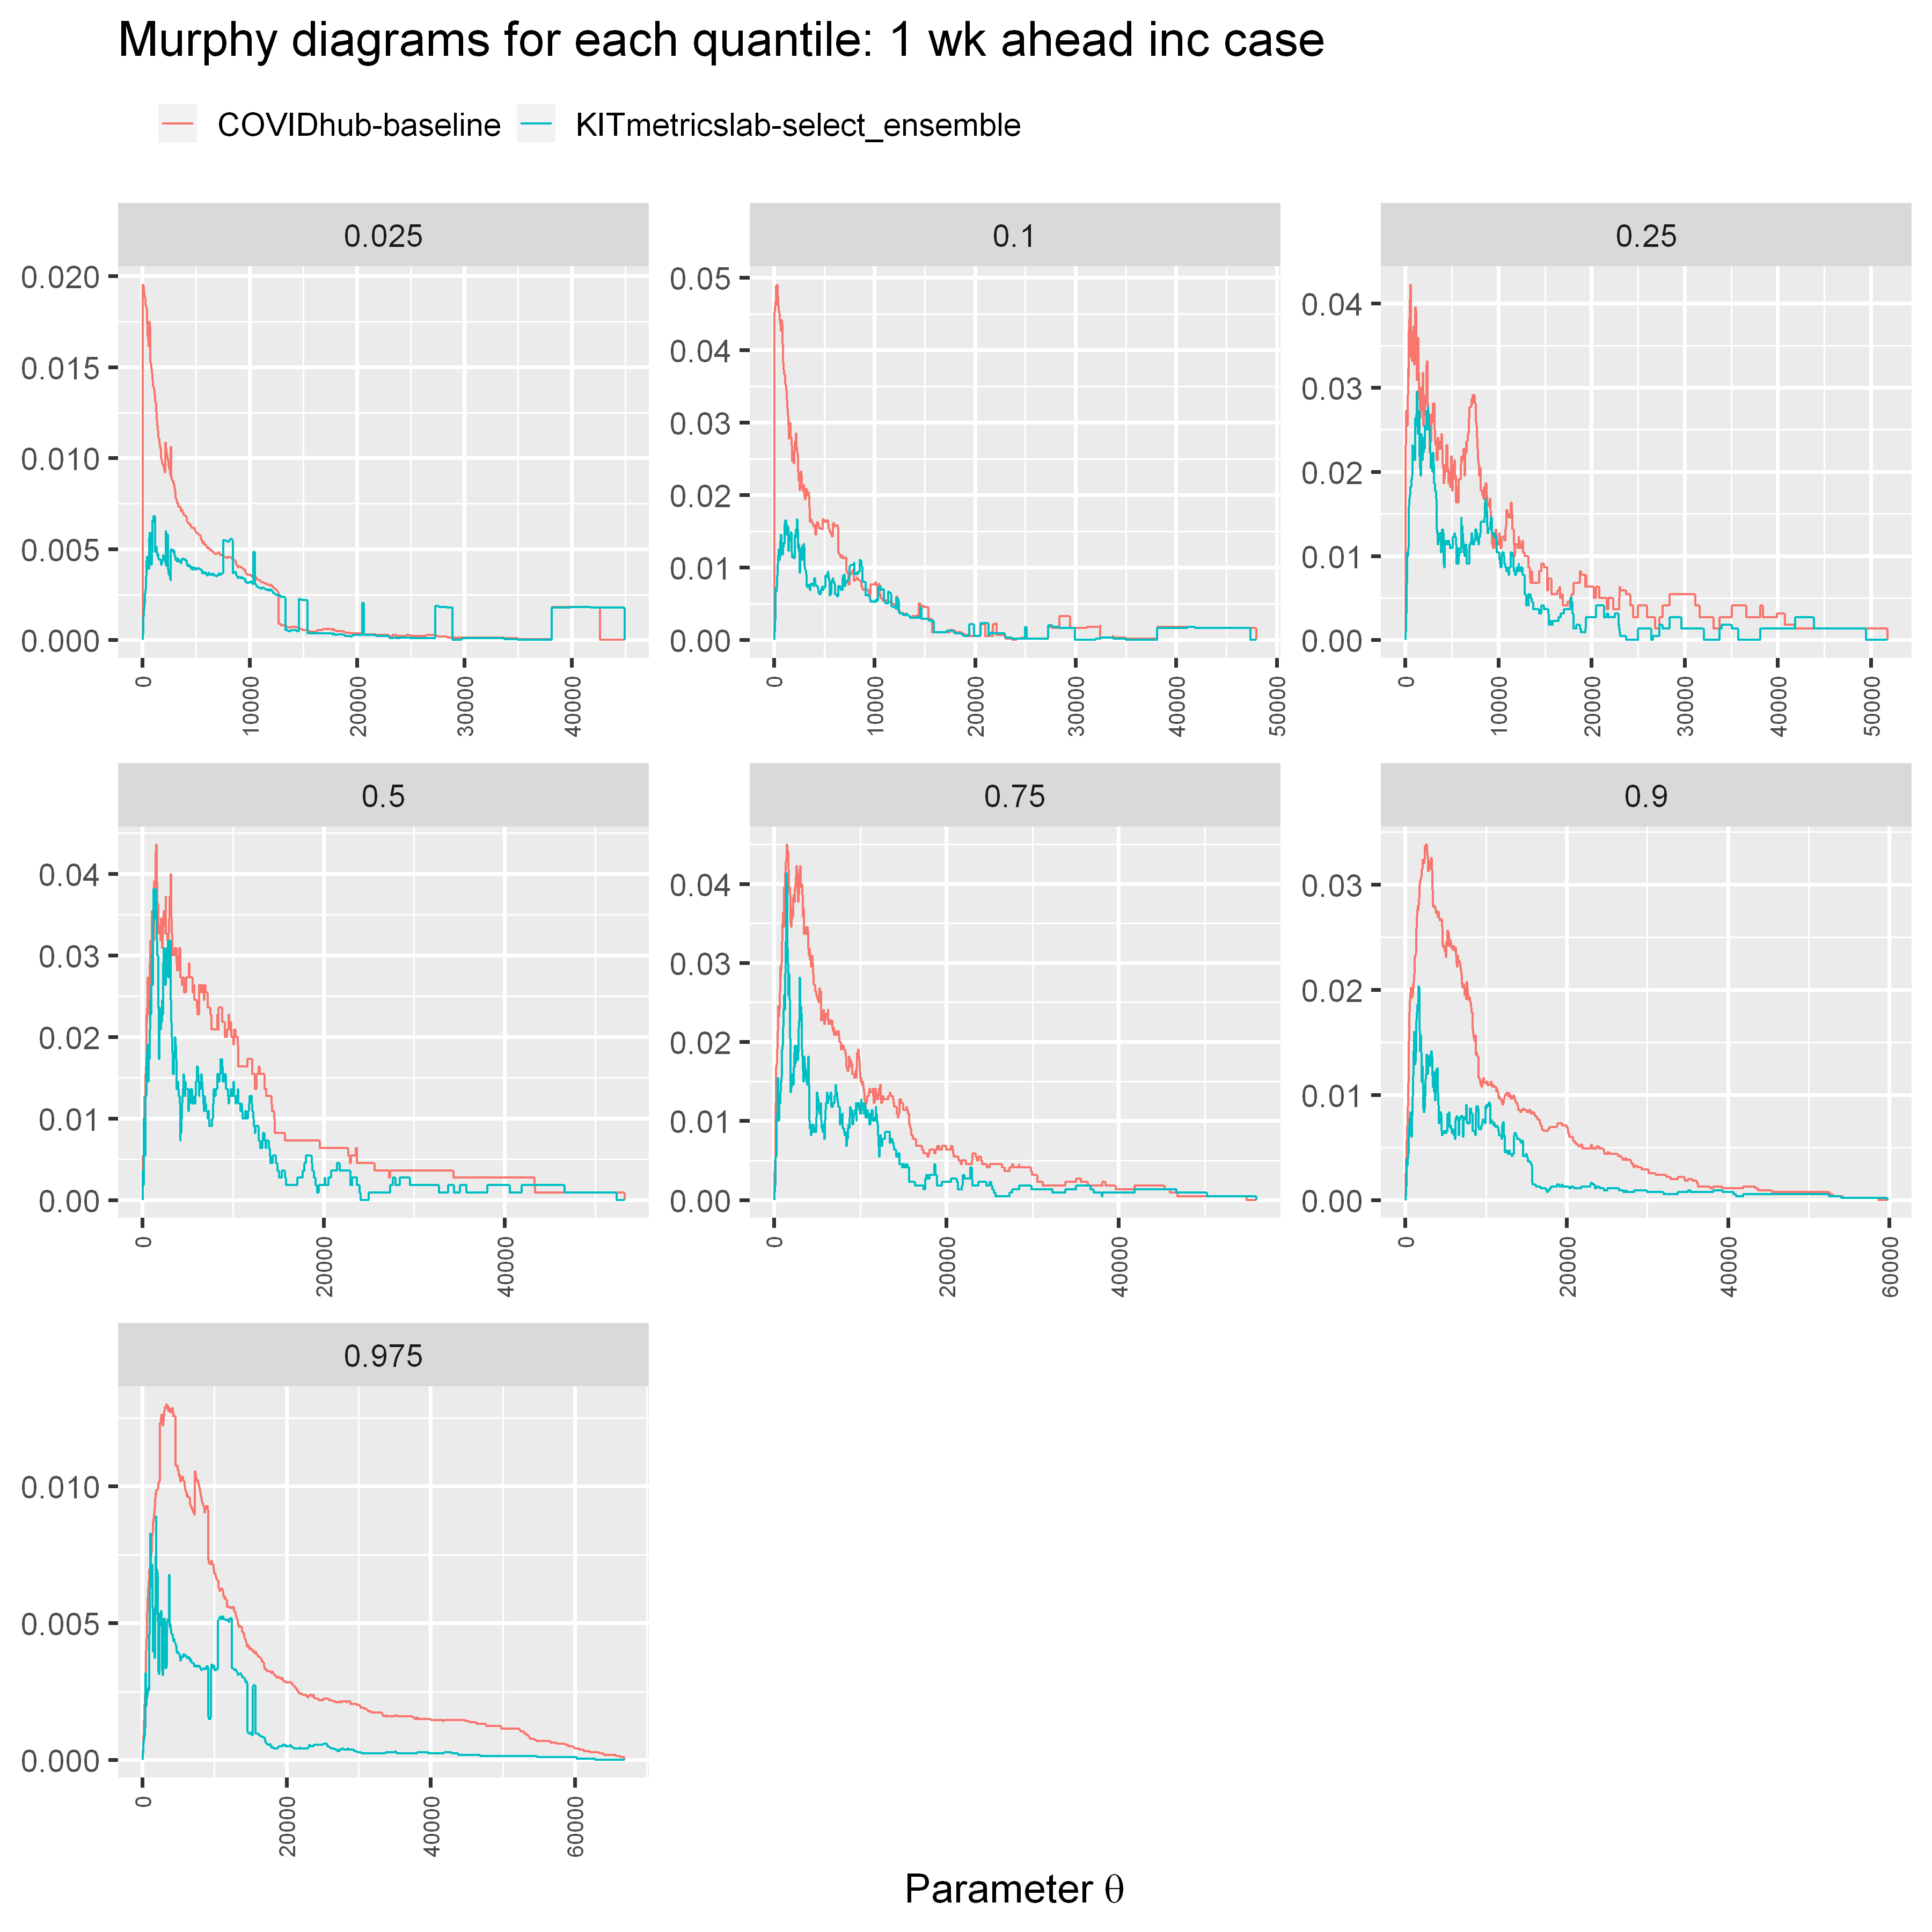

In [28]:
murphy_diagram_by_quantile(df, "KITmetricslab-select_ensemble", "COVIDhub-baseline", "1 wk ahead inc case")

### Comparison with COVIDhub-ensemble

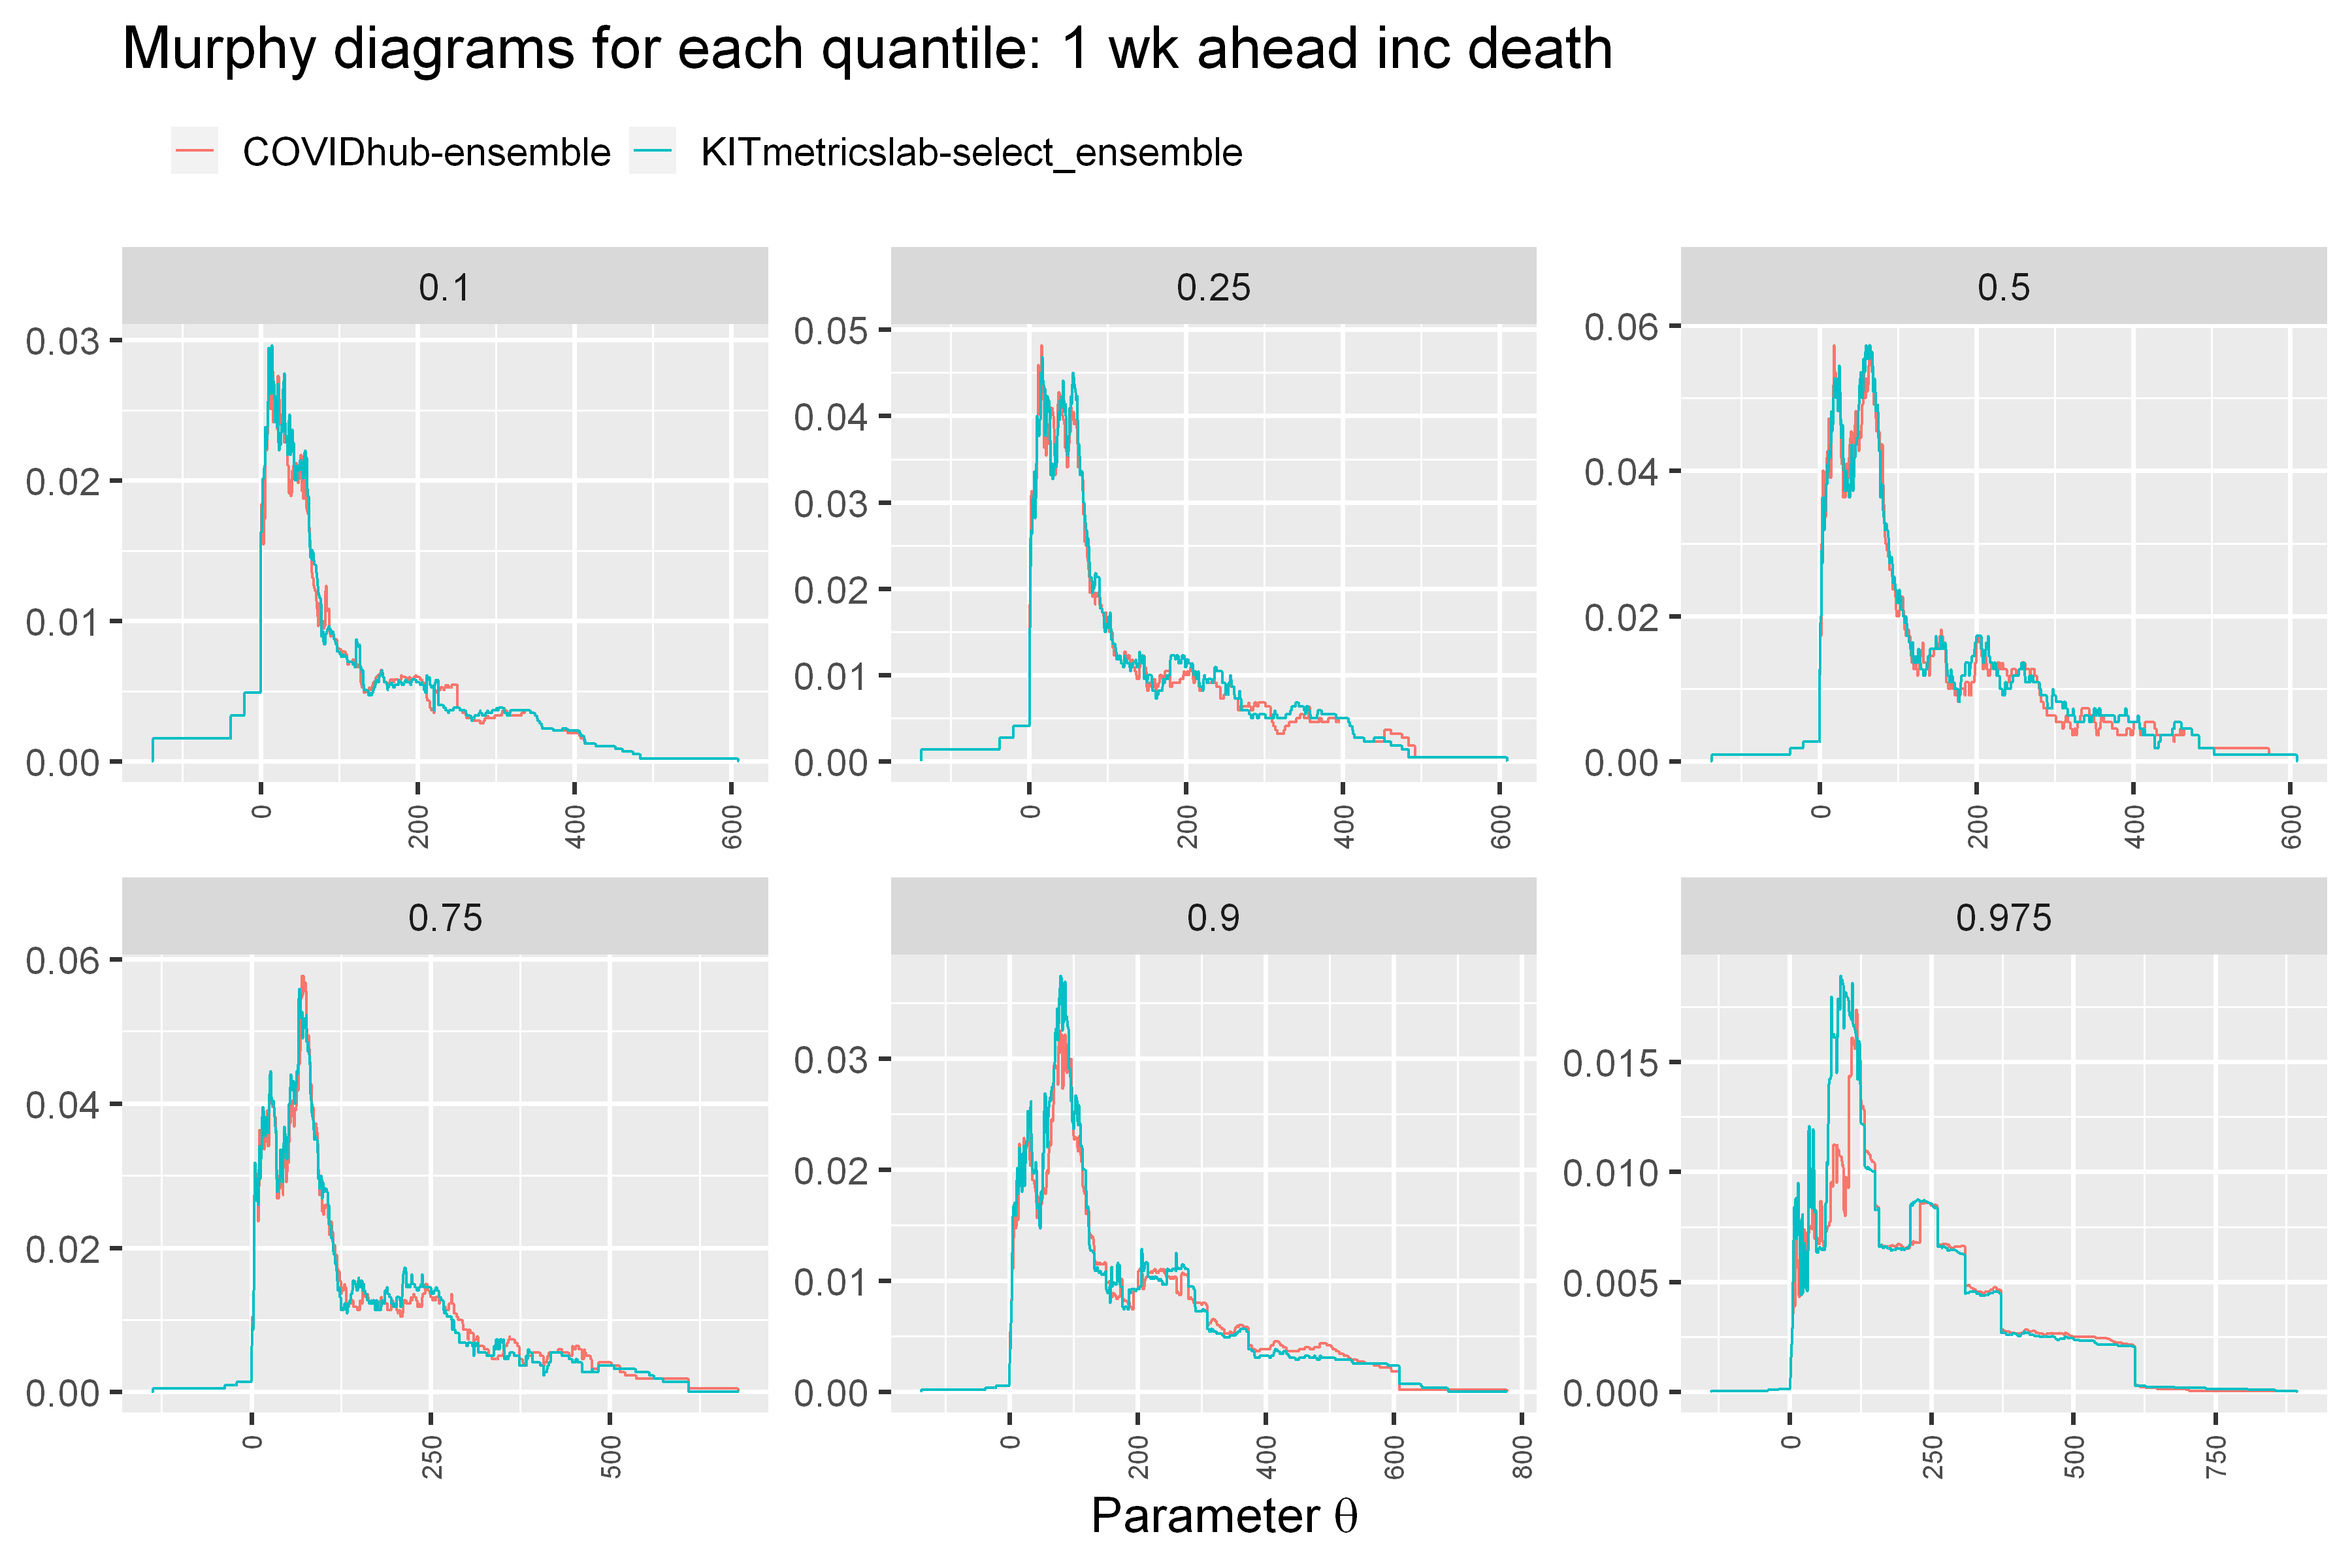

In [29]:
murphy_diagram_by_quantile(df, "KITmetricslab-select_ensemble", "COVIDhub-ensemble", "1 wk ahead inc death",
                          quantiles =  c(0.1, 0.25, 0.5, 0.75, 0.9, 0.975))

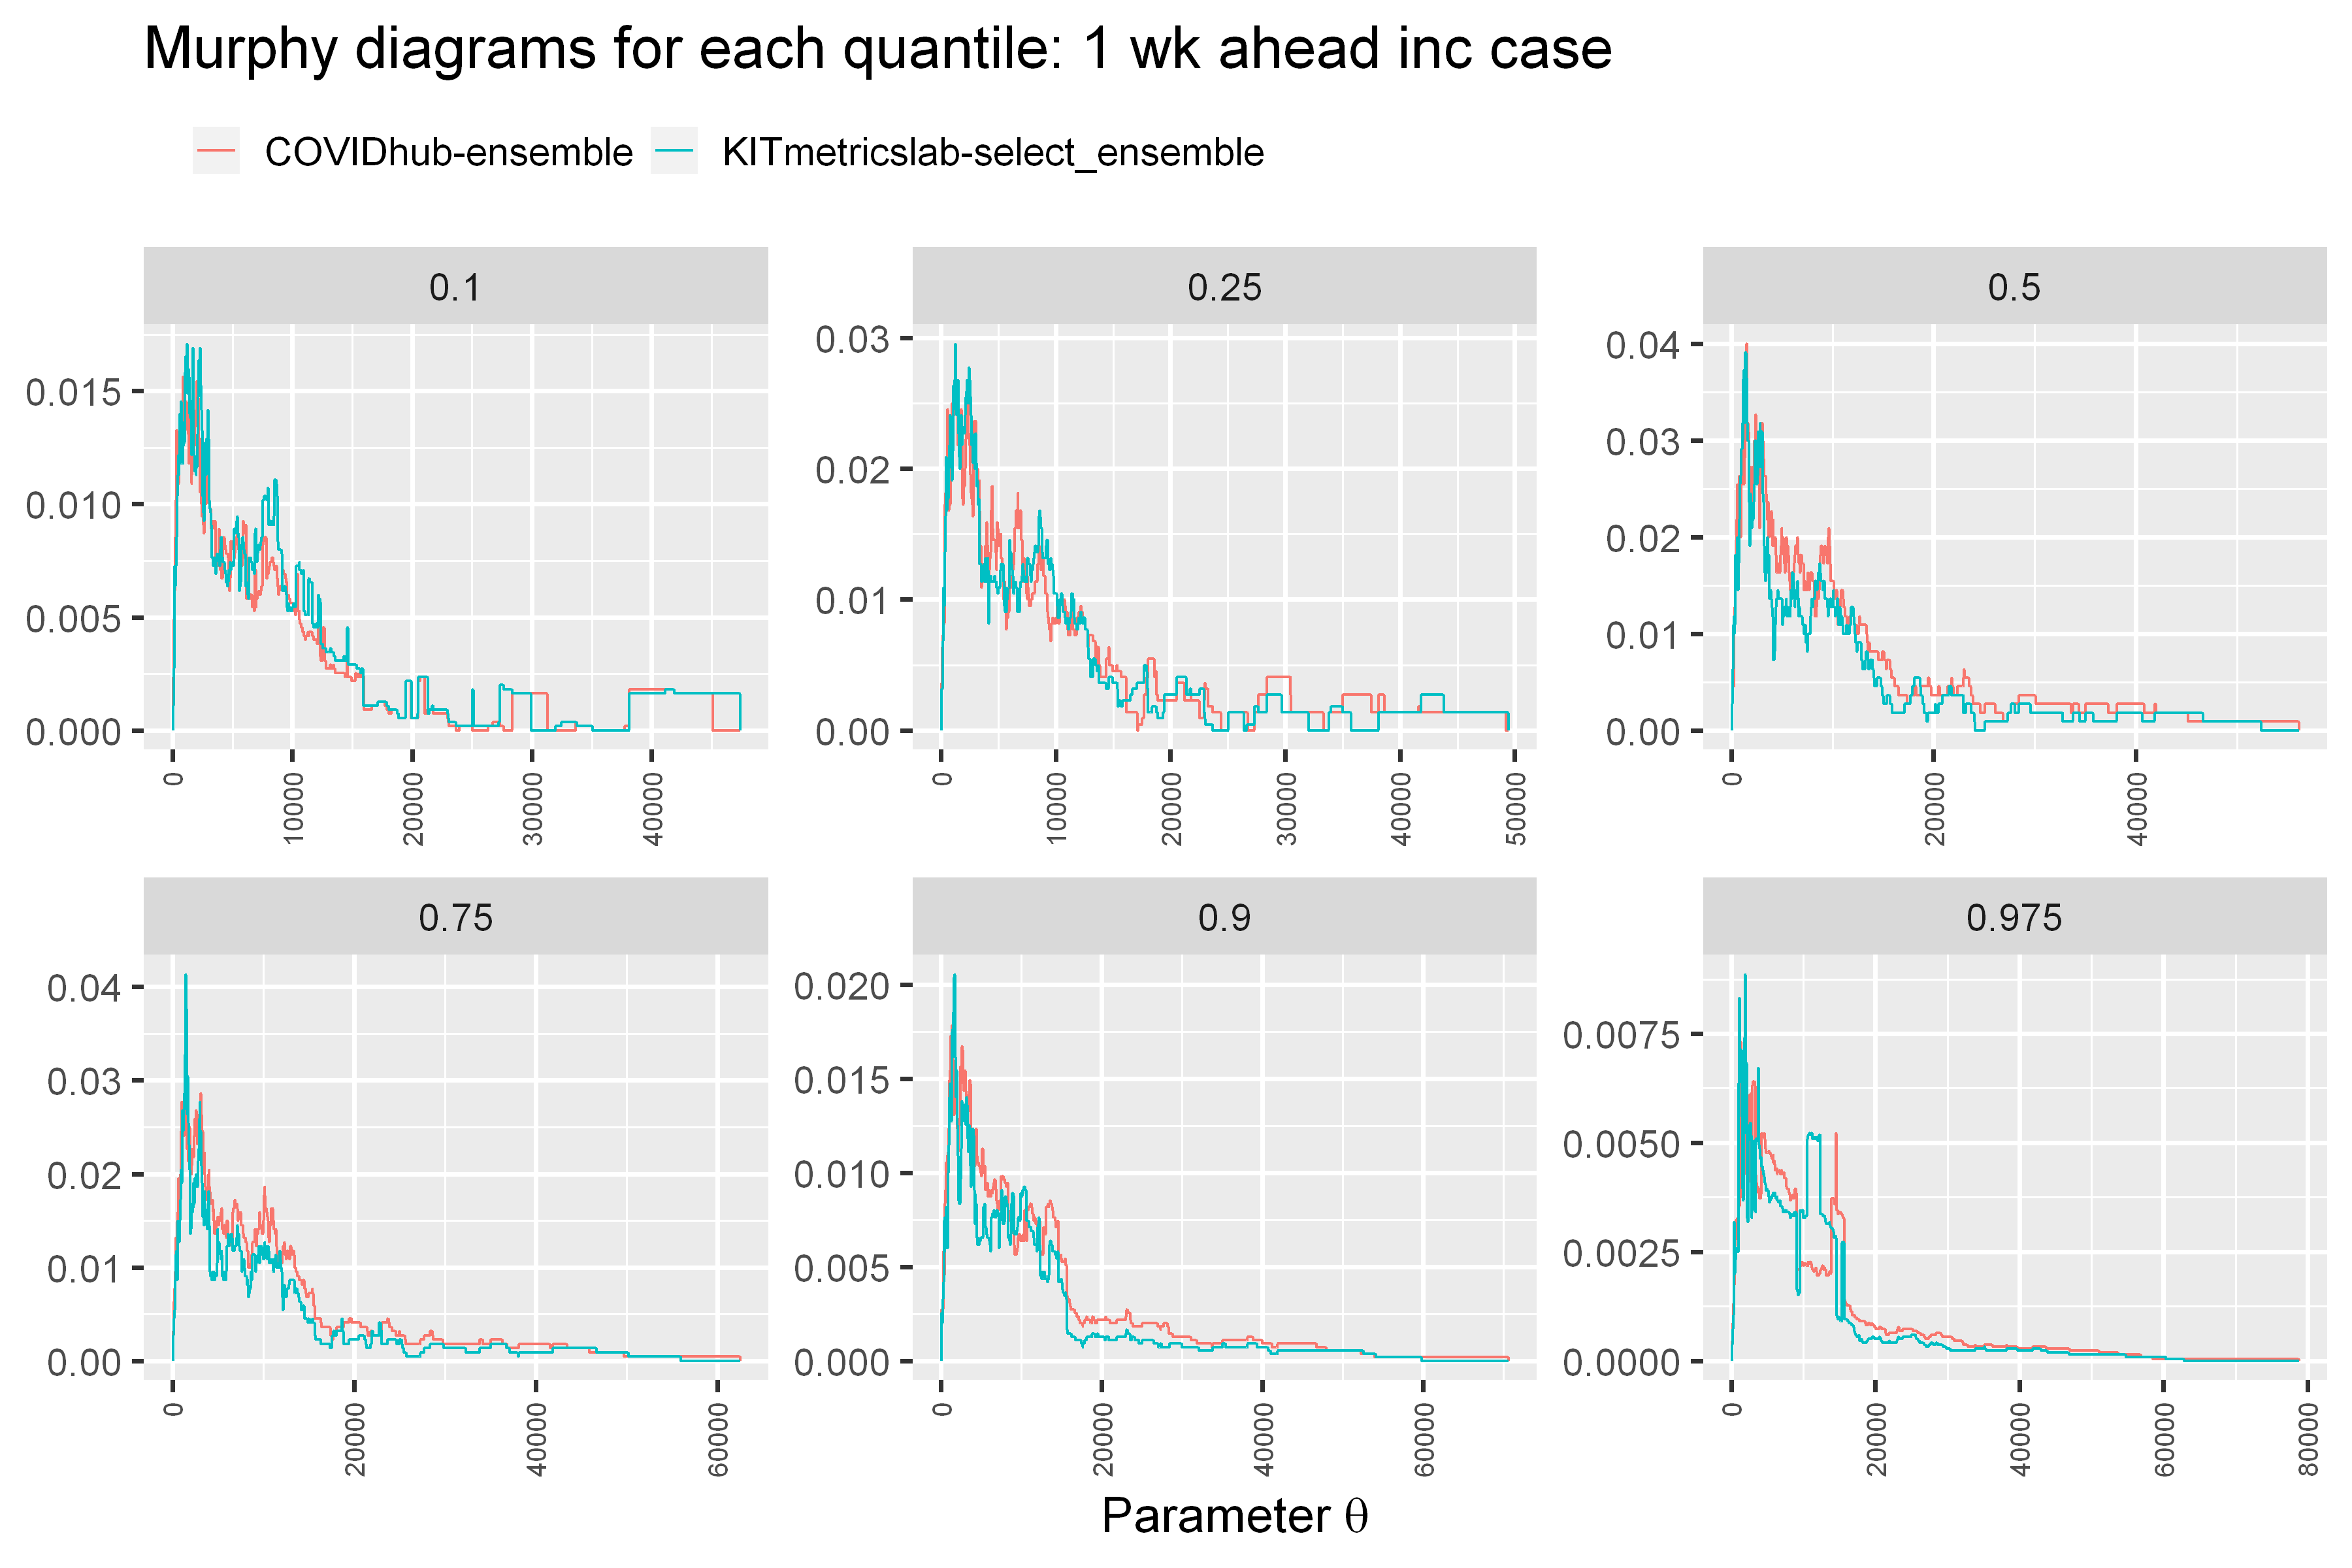

In [30]:
murphy_diagram_by_quantile(df, "KITmetricslab-select_ensemble", "COVIDhub-ensemble", "1 wk ahead inc case",
                          quantiles =  c(0.1, 0.25, 0.5, 0.75, 0.9, 0.975))

In [31]:
df <- read.csv(paste0("evaluation/", eval_date, "_df_processed.csv")) %>%
    filter(location != "US")

In [32]:
murphy_diagram_all <- function(df, model1 = "KITmetricslab-select_ensemble", model2 = "COVIDhub-baseline",
                                target = "case", 
                                quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975)){
    df <- df %>%
        filter((model == model1 | model == model2) & str_detect(target, !!target) & quantile %in% quantiles)
    
    df <- df %>% left_join(df %>%
                       group_by(target, quantile) %>%
                       do(crossing(theta = get_thetas(., n=501))),
                       by = c("target", "quantile"))

    df <- df %>%
      mutate(score = elementary_quantile_score(truth, value, theta, quantile))

    df <- df %>%
      group_by(target, model, quantile, theta) %>%
      summarize(mean_score = mean(score), .groups="keep")
    
    options(repr.plot.width=12, repr.plot.height=2*length(quantiles), repr.plot.res = 300)
    
    ggplot(df, aes(x=theta, y=mean_score, color=model)) +
      geom_line() +
      facet_grid(rows=vars(quantile), cols=vars(target), scales="free") +
      labs(title = paste0("Murphy diagrams for ", target, "s"), color = "Model") +
      xlab(expression(paste("Parameter ", theta))) +
      ylab(NULL) +
      theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1, size=10), 
            legend.position="top", legend.justification='left', legend.title=element_blank()) 
    }

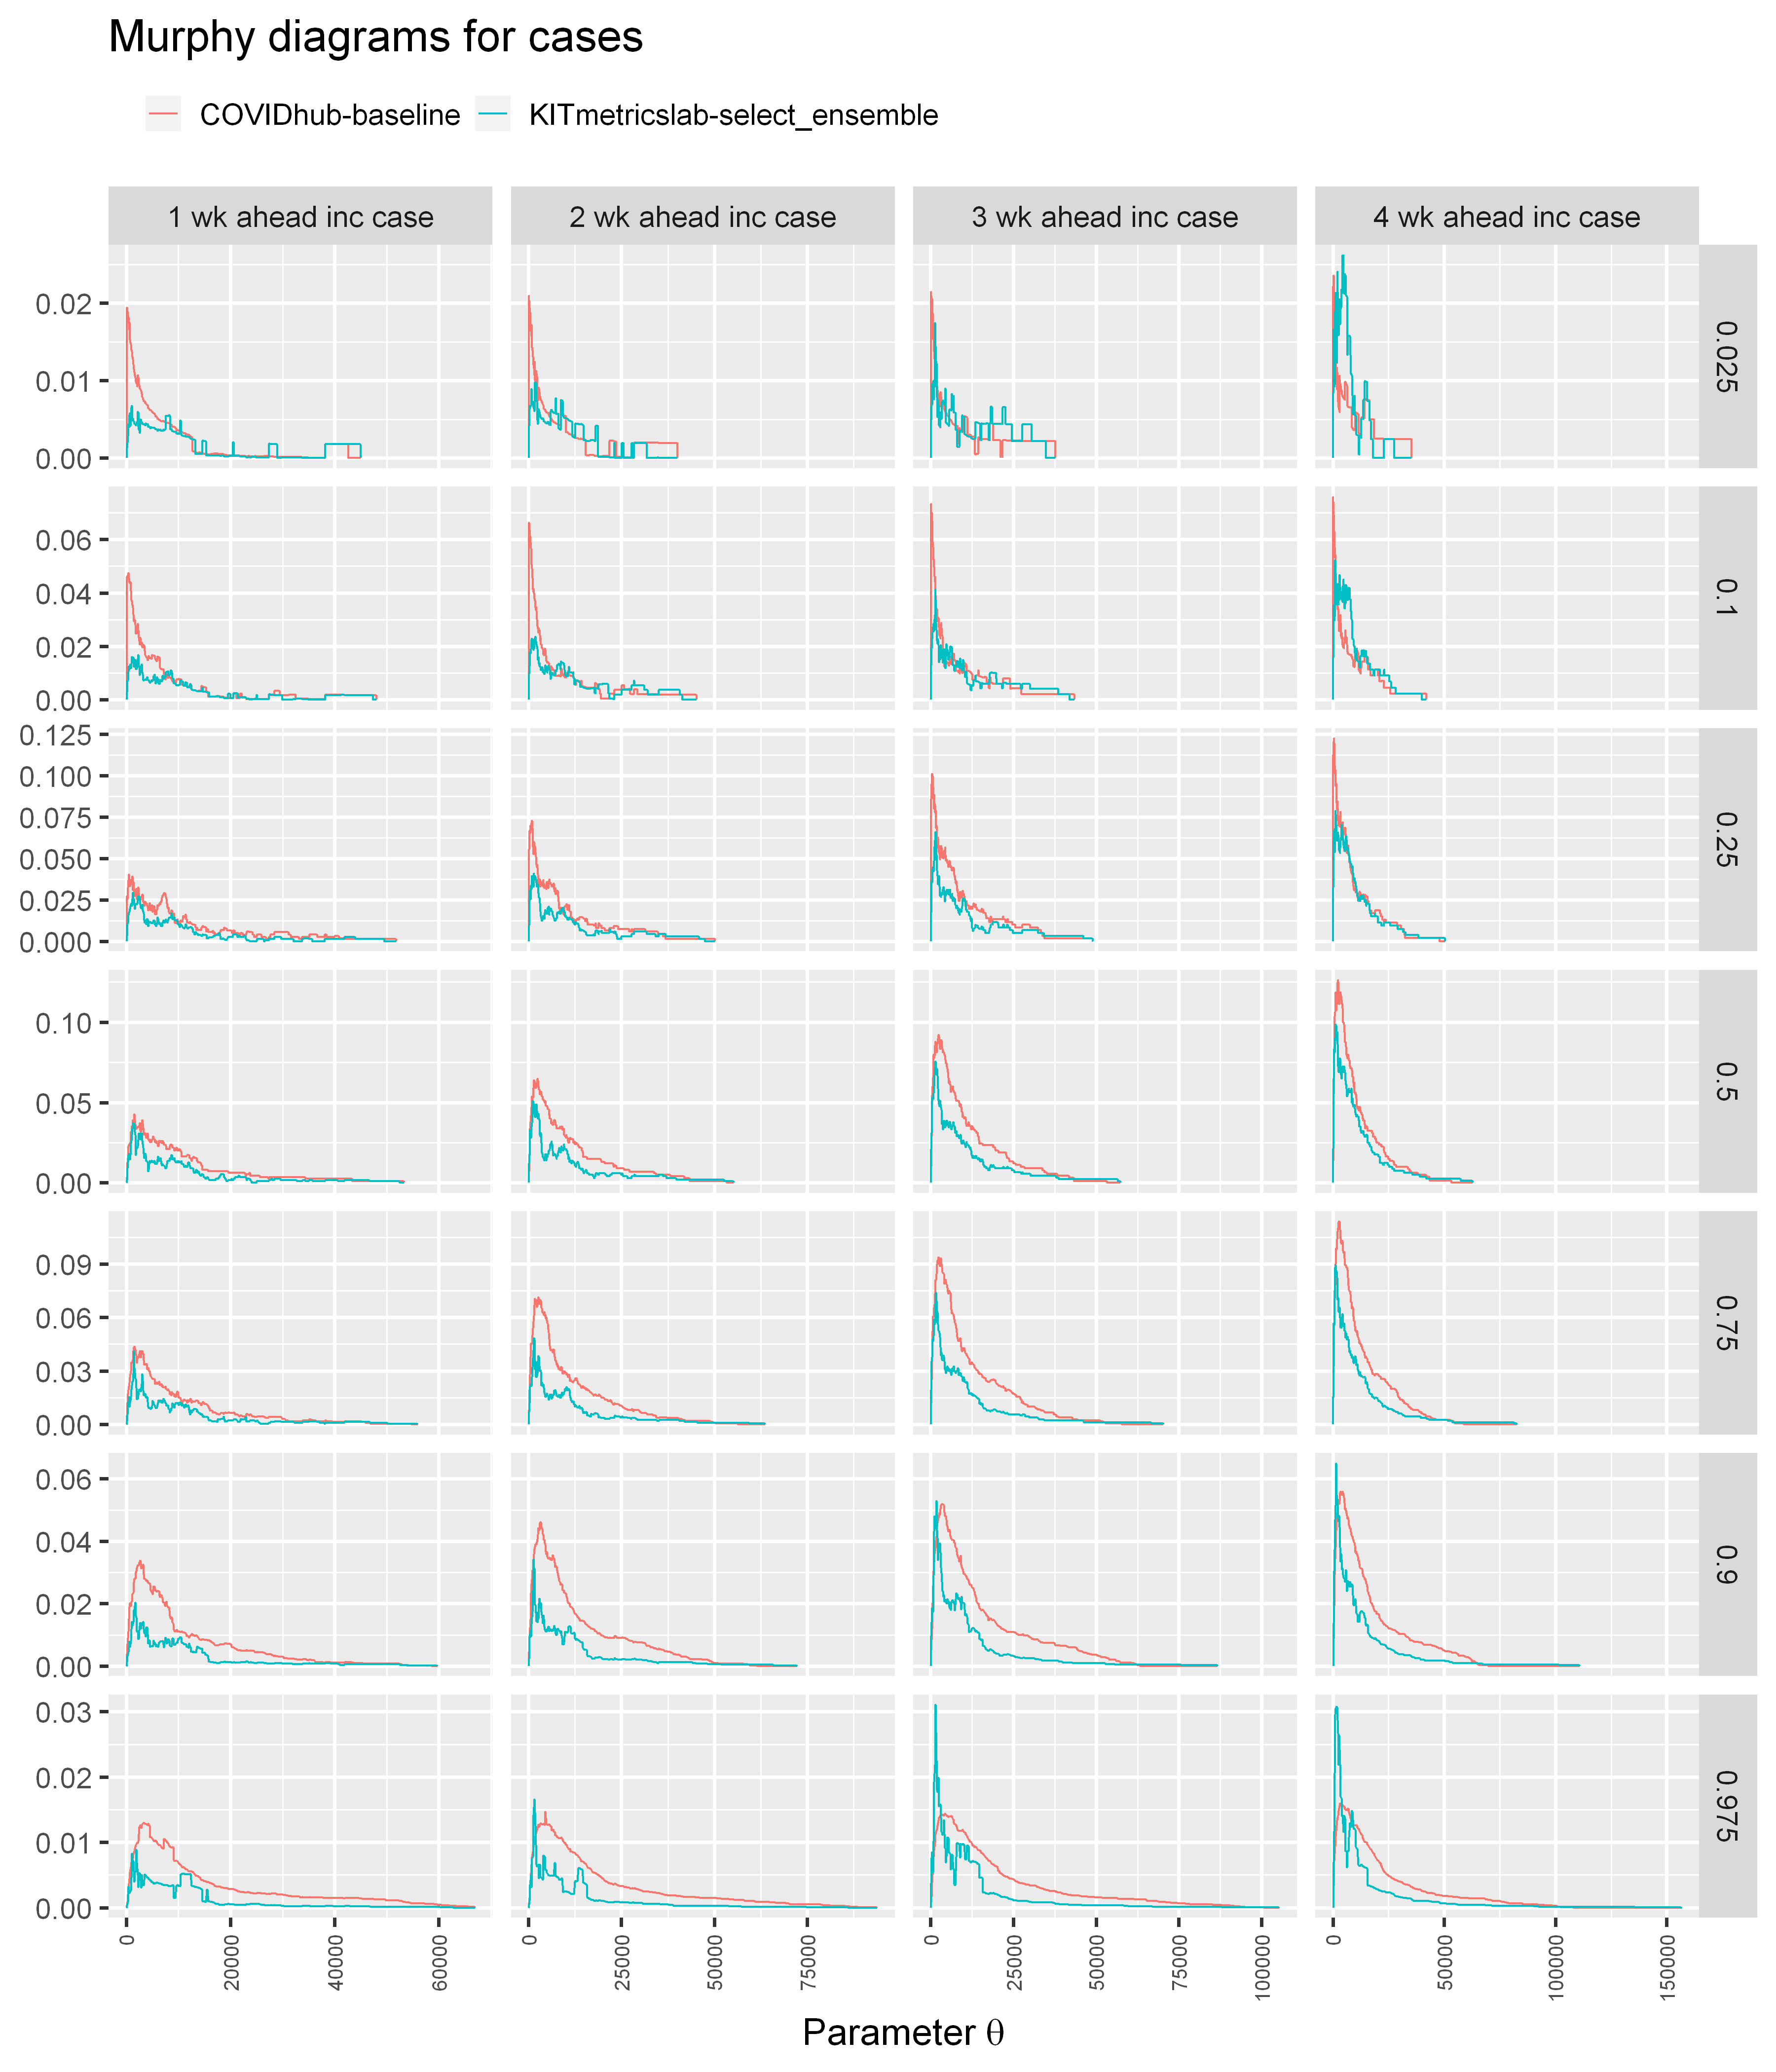

In [33]:
murphy_diagram_all(df, "KITmetricslab-select_ensemble", "COVIDhub-baseline", "case")

# Reliability Diagrams

In [34]:
reldiag = function(x, y, alpha = 0.5, n_resamples = 999, digits = 3, region_level = 0.9){

  require(isotone)
  pava = function(x,y) gpava(x,y,solver = weighted.fractile,p = alpha, ties = "secondary")$x
  score = function(x,y) mean(2*(as.numeric(x >= y) - alpha)*(x-y))
  marg = function(x) quantile(x,alpha)
  identif = function(x,y) as.numeric(x > y) - alpha
  score_label = "QS "
  
  ord_x = order(x)
  x = x[ord_x]
  y = y[ord_x]
  
  x_rc = pava(x,y)
  
  res = y - x
  
  s = score(x,y)
  s_rc_ucond = score(x + marg(res),y)
  s_rc = score(x_rc,y)
  s_mg = score(marg(y),y)
  
  mcb = s - s_rc
  umcb = s - s_rc_ucond
  cmcb = s_rc_ucond - s_rc
  dsc = s_mg - s_rc
  unc = s_mg
  
  # test: mean identification zero? (t-test)
  v = identif(x,y)
  t = sqrt(length(v)) * mean(v)/sd(v)
  pval_ucond = 1 - abs(pt(t,length(v)-1) - 0.5)*2
  
  n_samples = n_resamples + 1 # total number of samples including observed sample
  low = floor(n_samples * (1-region_level)/2)
  up = n_samples - low
  pval_digits = ceiling(log(n_samples,10))

  resamples = sapply(1:n_resamples,function(i) x + sample(res,length(y))) 

  x_rc_resamples = apply(resamples, 2, function(y) pava(x,y))
  x_rc_resamples_sorted = apply(cbind(x_rc,x_rc_resamples),1,sort) - marg(res) # includes observed values + bias corrected (shifted by mean residual)

  ran_x = range(x)

  mcb_resamples = sapply(1:n_resamples,function(i) score(x,resamples[,i]) - score(x_rc_resamples[,i],resamples[,i]))
  mcb_bounds = sort(c(mcb,mcb_resamples))[c(low,up)]

  rank_obs = tail(rank(c(mcb_resamples,mcb)),1)
  pval = 1 - (rank_obs - 1)/(n_resamples + 1)
  
  results <- data.frame(quantile = alpha, x = x, y = y, x_rc = x_rc,
                        lower = x_rc_resamples_sorted[low,],
                        upper = x_rc_resamples_sorted[up,],
                        score = s,
                        umcb = umcb, cmcb = cmcb, mcb = mcb, dsc = dsc, unc = unc,
                        pval_cond = pval, pval_ucond = pval_ucond)
}

In [35]:
reliability_diagram <- function(df, model = "COVIDhub-baseline",
                                target = "1 wk ahead inc case", 
                                quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975),
                                n_resamples = 999){
    df <- df %>%
        filter(model == !!model & target == !!target & quantile %in% quantiles)
    
    # compute recalibration, consistency band and score decomposition
    results <- df %>%
      group_by(quantile) %>%
      do(reldiag(.$value, .$truth, alpha = unique(.$quantile), n_resamples = n_resamples))
    
    # summarize scores and create labels
    scores <- results %>%
        group_by(quantile) %>%
        distinct(across(score:pval_ucond)) %>%
        mutate(label = paste0(c("QS ", "uMCB ","cMCB ","DSC ","UNC "),
                                round(c(score, umcb, cmcb, dsc, unc), digits = 3),
                                c("", paste0(" [p = ", round(pval_ucond, digits = 3),"]"), "", "", ""),
                                c("", "", paste0(" [p = ", round(pval_cond, digits = 3),"]"), "", ""),
                                collapse = "\n"))
        
    # needed to ensure square facets with equal x and y limits
    facet_lims <- results %>%
        group_by(quantile) %>%
        summarize(mn = min(c_across(c(x, x_rc, lower, upper))), 
                  mx = max(c_across(c(x, x_rc, lower, upper))))
    
    options(repr.plot.width=15, repr.plot.height=5*ceiling(length(quantiles)/3), repr.plot.res = 400)
    
    ggplot(results, aes(x, x_rc)) +
        facet_wrap("quantile", scales="free", ncol=3) +
        #geom_point(aes(x, y), alpha=0.2) +
        geom_abline(intercept = 0 , slope = 1) +
        geom_point(color = "red") +
        geom_step(color = "red", direction = "vh") +    
        geom_smooth(aes(ymin = lower, ymax = upper), linetype = 0, stat = "identity", fill = "skyblue3") +
        geom_rug(sides = "b", alpha = 0.2) +
        geom_blank(data = facet_lims, aes(x = mx, y = mx)) +
        geom_blank(data = facet_lims, aes(x = mn, y = mn)) +
        xlab("Forecast value") +
        ylab("Conditional quantile") +
        labs(title = paste(model, ":", target))  +
        geom_label(data = scores, mapping = aes(x = -Inf, y = Inf, label = label),
                   size = 4, hjust = 0, vjust = 1, label.size = NA, alpha=0, label.padding = unit(1, "lines")) +
        scale_x_continuous(guide = guide_axis(check.overlap = TRUE)) +
        theme_gray(base_size = 18)    
}

In [36]:
df <- read.csv(paste0("evaluation/", eval_date, "_df_processed.csv")) %>%
    filter(location != "US")

Loading required package: isotone



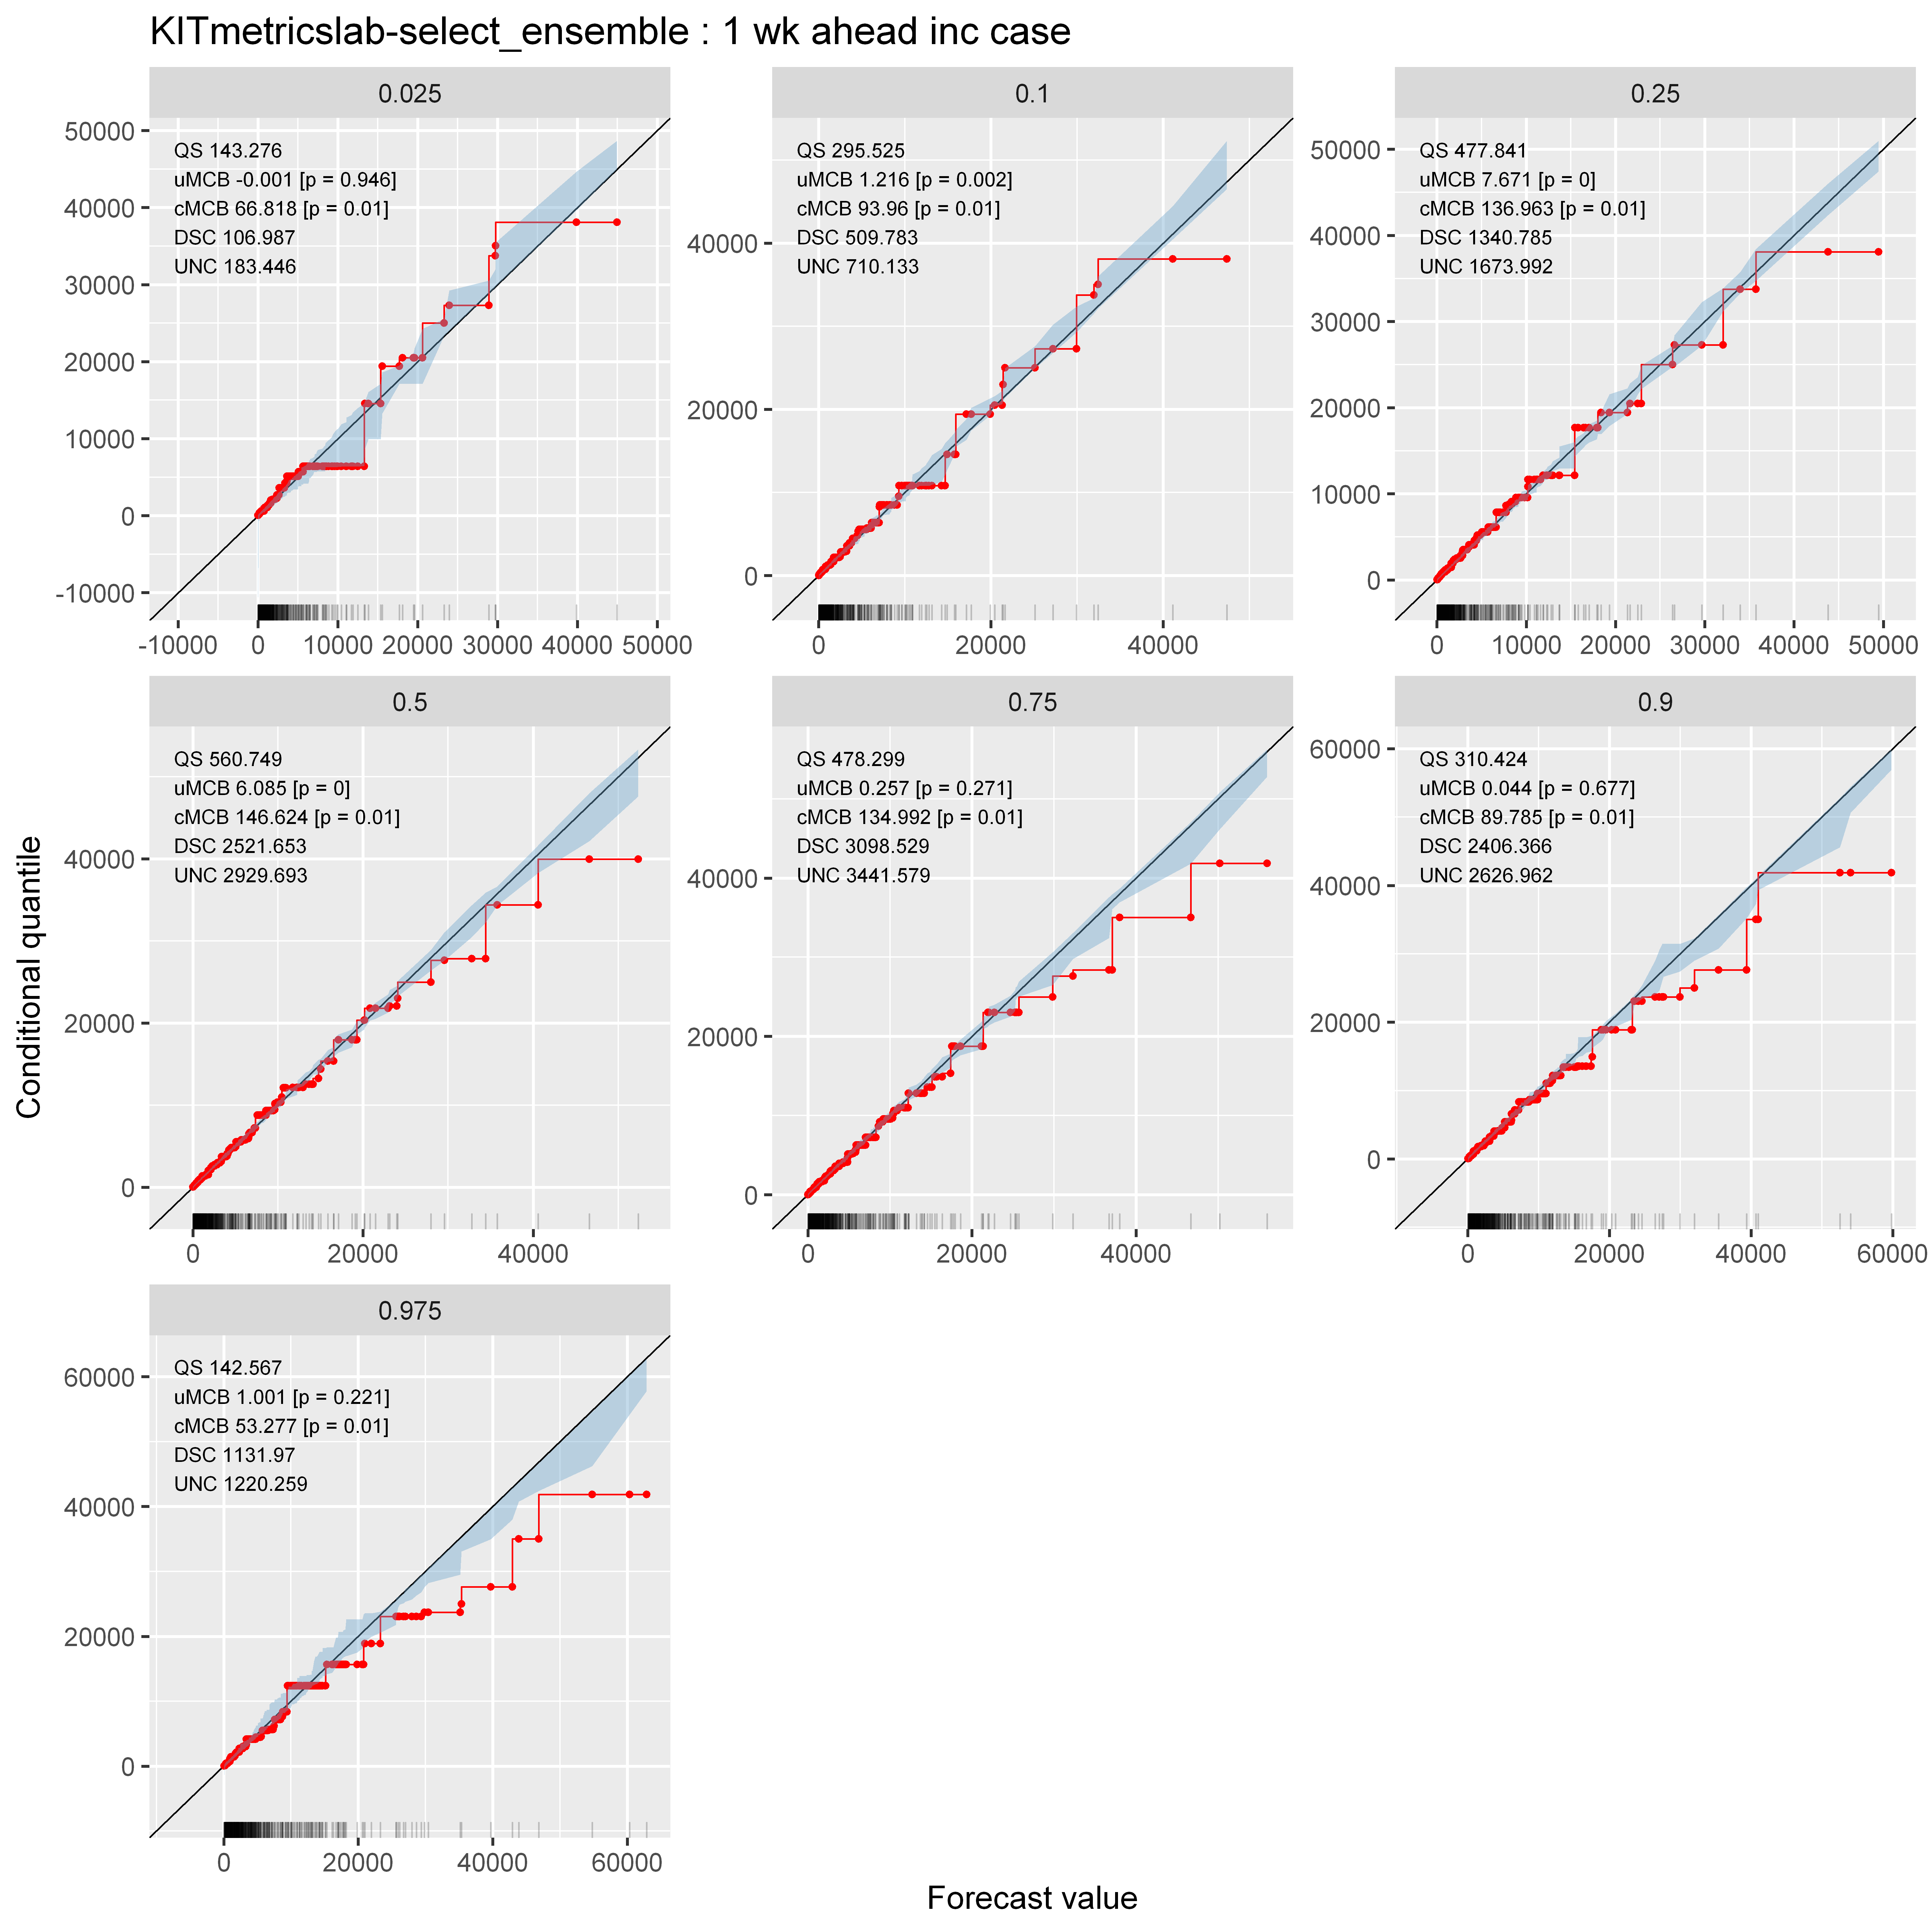

In [37]:
reliability_diagram(df, model = "KITmetricslab-select_ensemble", target = "1 wk ahead inc case", n_resamples = 99)

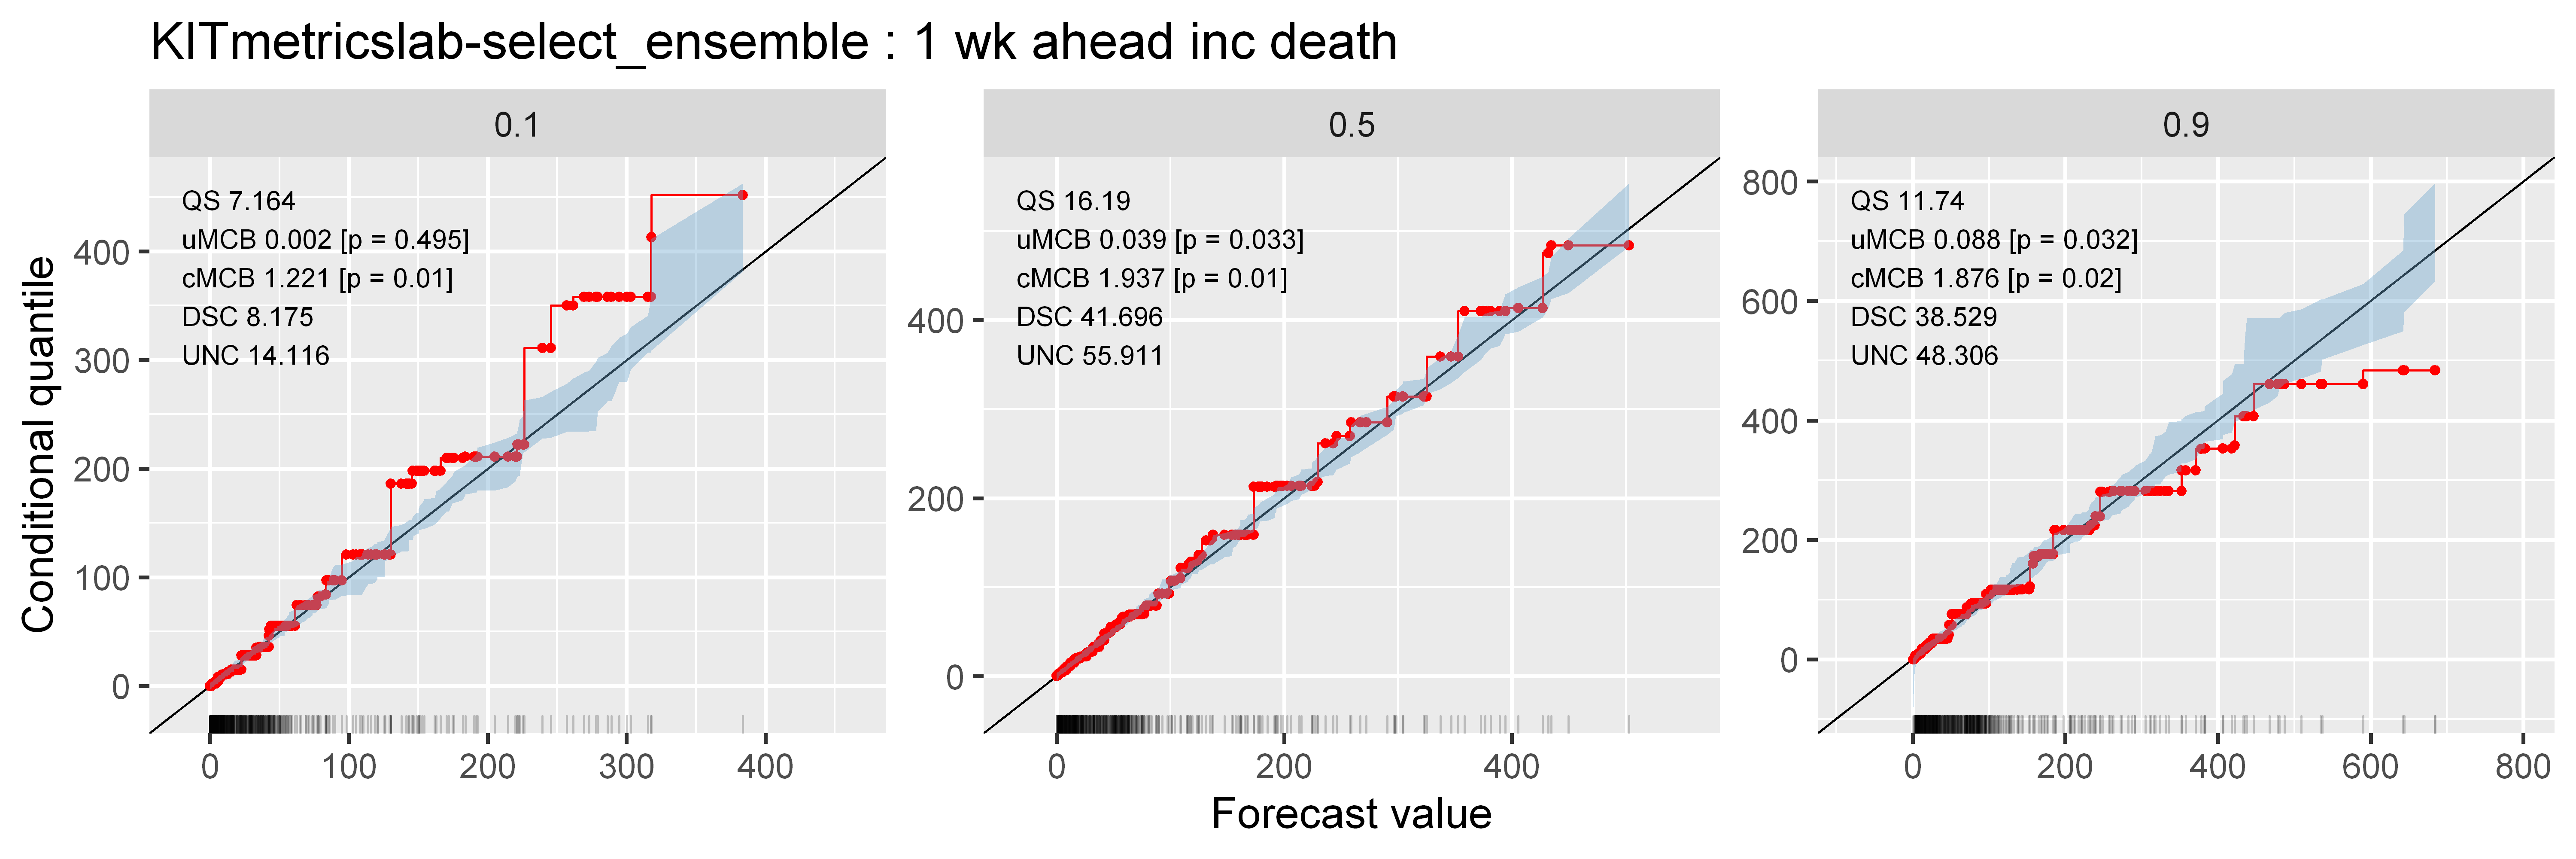

In [38]:
reliability_diagram(df, "KITmetricslab-select_ensemble", "1 wk ahead inc death", c(0.1, 0.5, 0.9), n_resamples = 99)

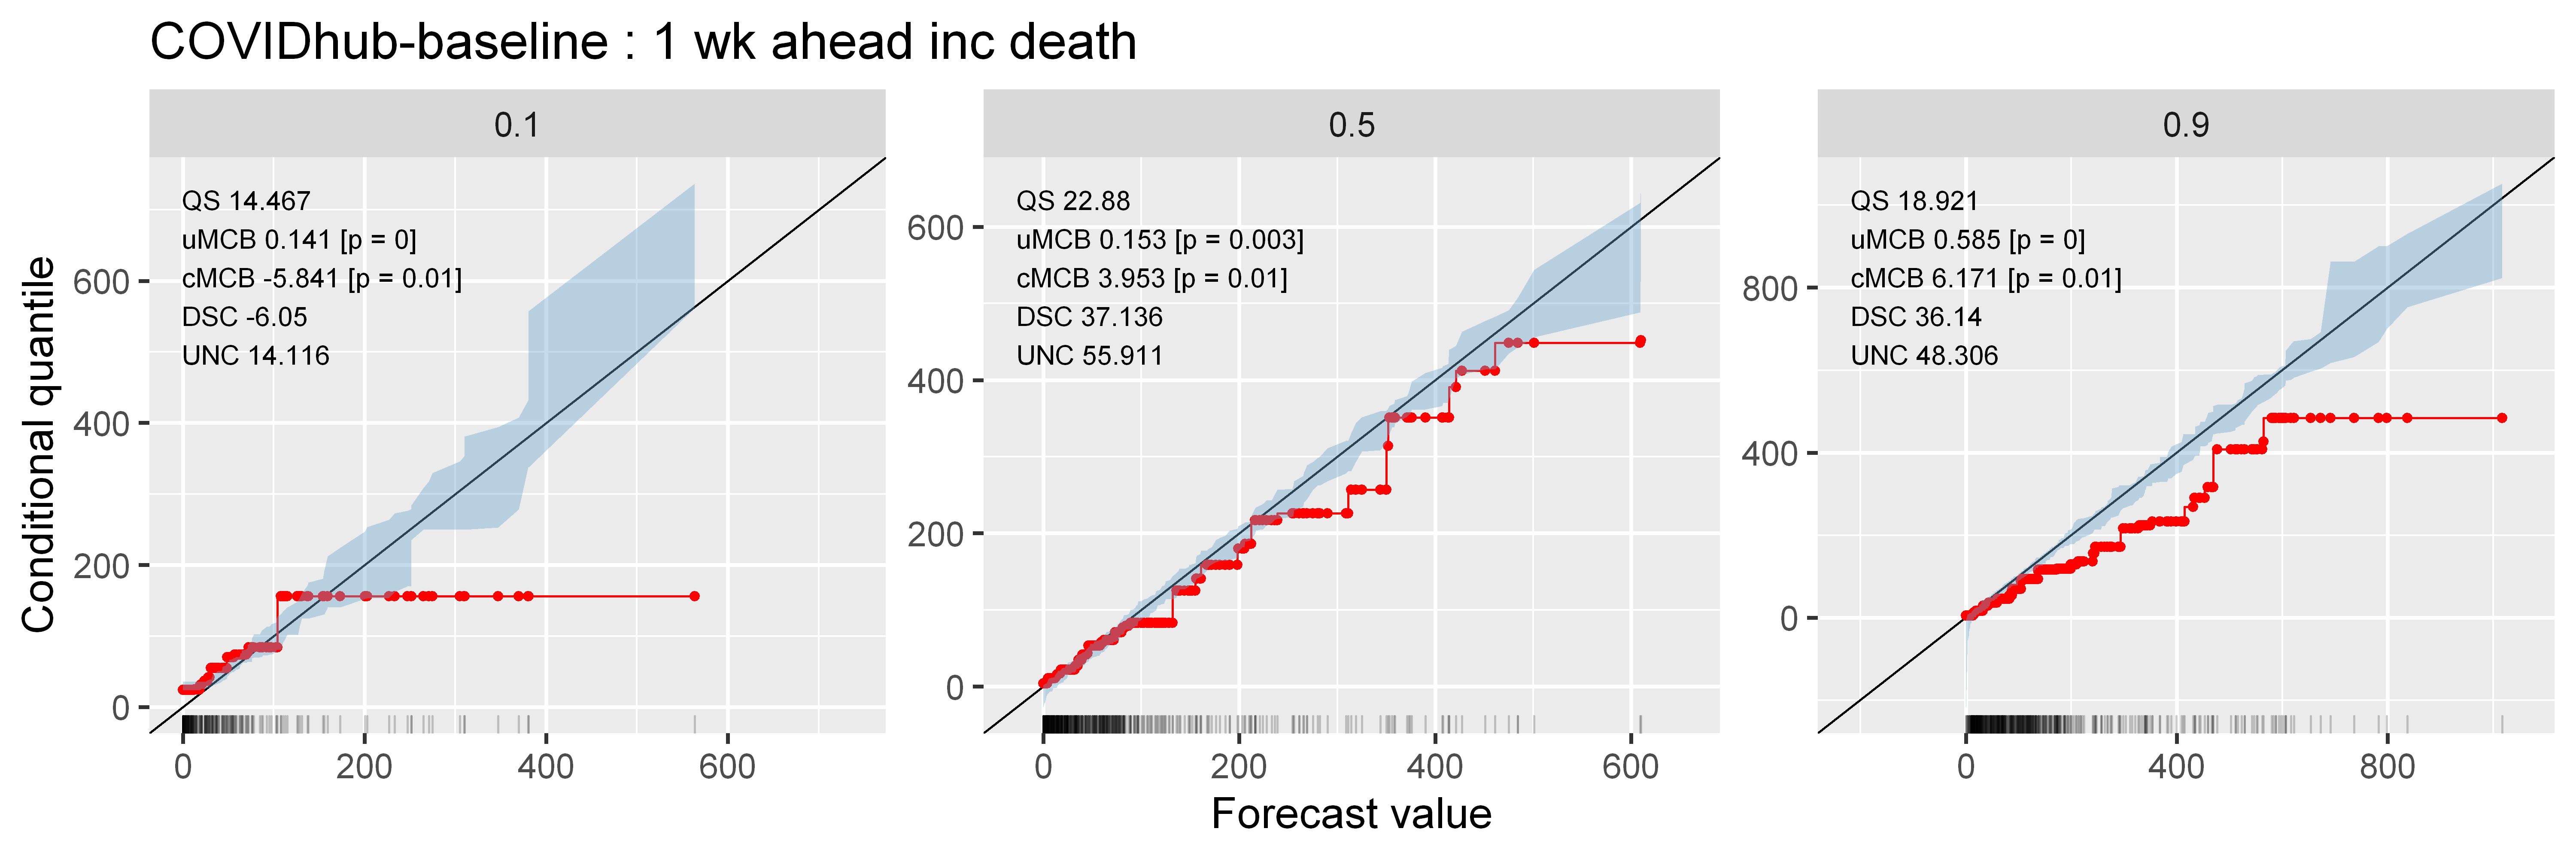

In [39]:
reliability_diagram(df, "COVIDhub-baseline", "1 wk ahead inc death", c(0.1, 0.5, 0.9), n_resamples = 99)

In [40]:
reliability_diagram_all <- function(df, model = "COVIDhub-baseline",
                                target = "case", 
                                quantiles = c(0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975),
                                n_resamples = 999){
    df <- df %>%
        filter(model == !!model & str_detect(target, !!target) & quantile %in% quantiles)
    
    # compute recalibration, consistency band and score decomposition
    results <- df %>%
      group_by(target, quantile) %>%
      do(reldiag(.$value, .$truth, alpha = unique(.$quantile), n_resamples = n_resamples))
    
    # summarize scores and create labels
    scores <- results %>%
        group_by(target, quantile) %>%
        distinct(across(score:pval_ucond)) %>%
        mutate(label = paste0(c("QS ", "uMCB ","cMCB ","DSC ","UNC "),
                                round(c(score, umcb, cmcb, dsc, unc), digits = 3),
                                c("", paste0(" [p = ", round(pval_ucond, digits = 3),"]"), "", "", ""),
                                c("", "", paste0(" [p = ", round(pval_cond, digits = 3),"]"), "", ""),
                                collapse = "\n"))
        
    # needed to ensure square facets with equal x and y limits
    facet_lims <- results %>%
        group_by(target, quantile) %>%
        summarize(mn = min(c_across(c(x, x_rc))), 
                  mx = max(c_across(c(x, x_rc))), .groups = "keep")

    options(repr.plot.width=16, repr.plot.height=4*length(quantiles), repr.plot.res = 300)

    g <- ggplot(results, aes(x, x_rc)) +
        facet_wrap(quantile ~ target, scales="free", ncol=4) +
        #geom_point(aes(x, y), alpha=0.2) +
        geom_abline(intercept = 0 , slope = 1) +
        geom_point(color = "red") +
        geom_step(color = "red", direction = "vh") +    
        geom_smooth(aes(ymin = lower, ymax = upper), linetype = 0, stat = "identity", fill = "skyblue3") +
        geom_rug(sides = "b", alpha = 0.2) +
        geom_blank(data = facet_lims, aes(x = mx, y = mx)) +
        geom_blank(data = facet_lims, aes(x = mn, y = mn)) +
        xlab("Forecast value") +
        ylab("Conditional quantile") +
        labs(title = paste0(model, ": ", target, "s"))  +
        geom_label(data = scores, mapping = aes(x = -Inf, y = Inf, label = label),
                   size = 4, hjust = 0, vjust = 1, label.size = NA, alpha=0, label.padding = unit(1, "lines")) +
        scale_x_continuous(limits = c(0, NA), guide = guide_axis(check.overlap = TRUE)) +
        scale_y_continuous(limits = c(0, NA), guide = guide_axis(check.overlap = TRUE)) +
        theme_gray(base_size = 18)   
    
    print(g)
    invisible(results)
}

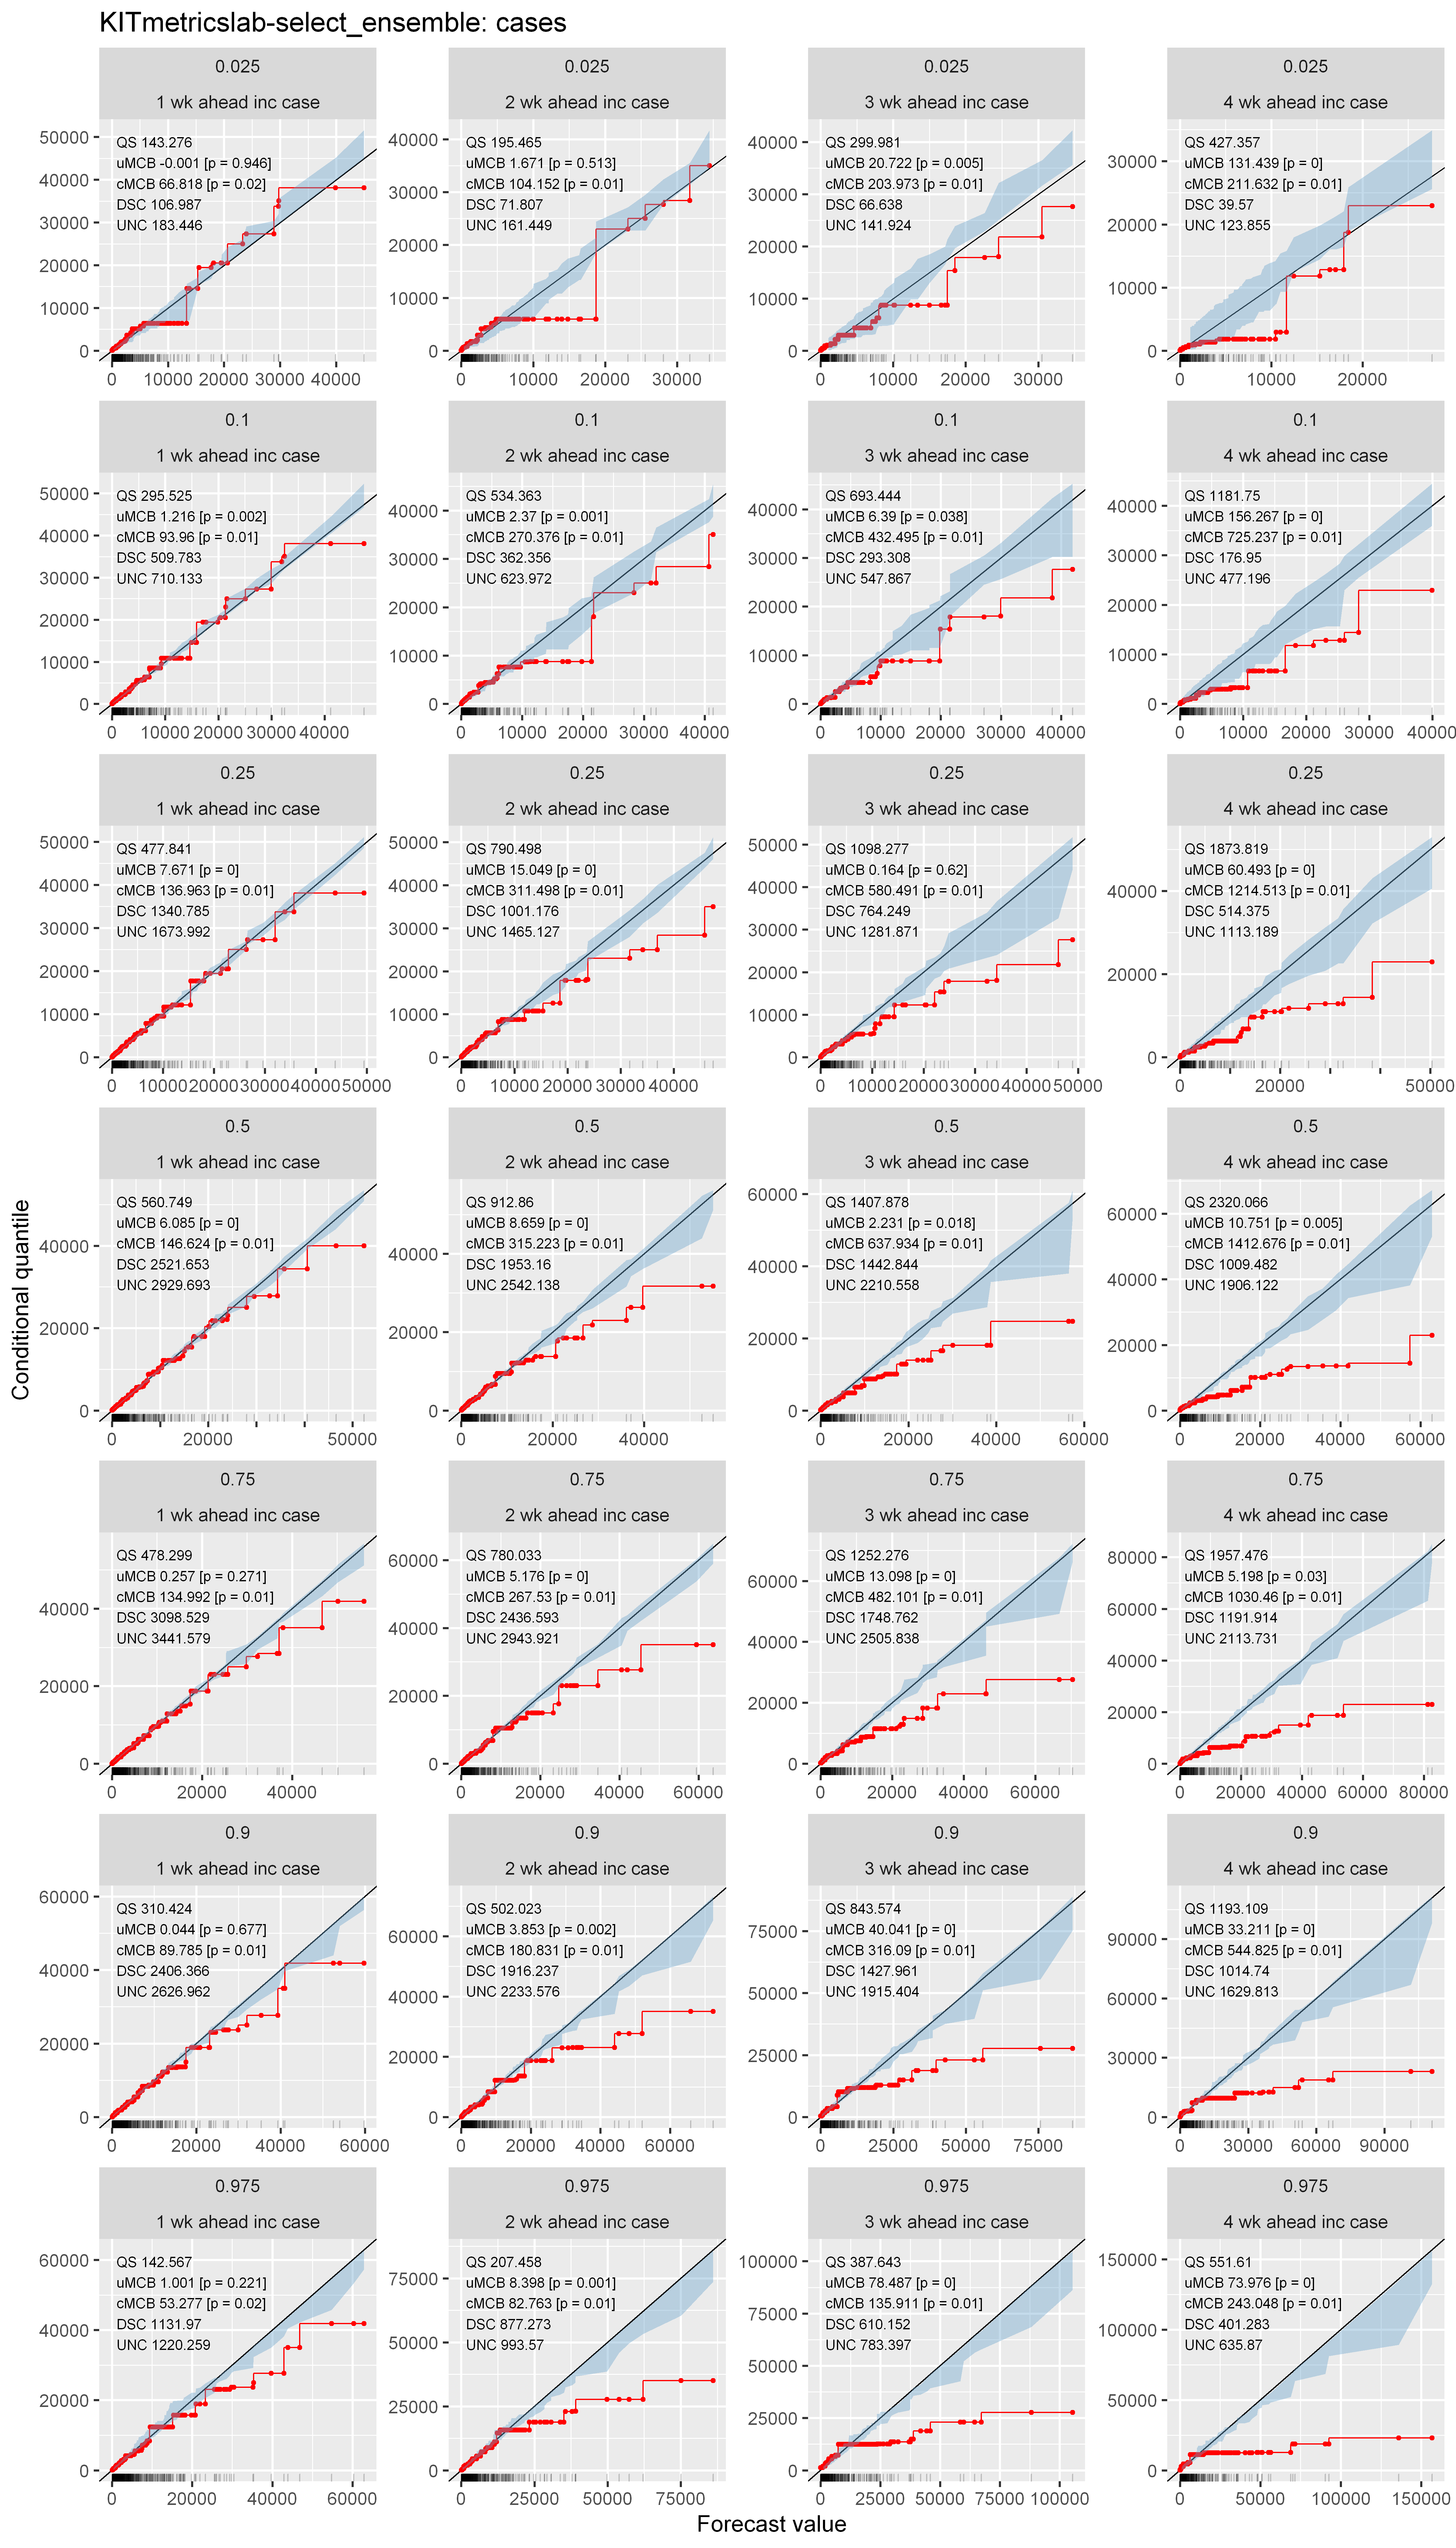

In [41]:
r <- reliability_diagram_all(df, "KITmetricslab-select_ensemble", "case", n_resamples = 99)

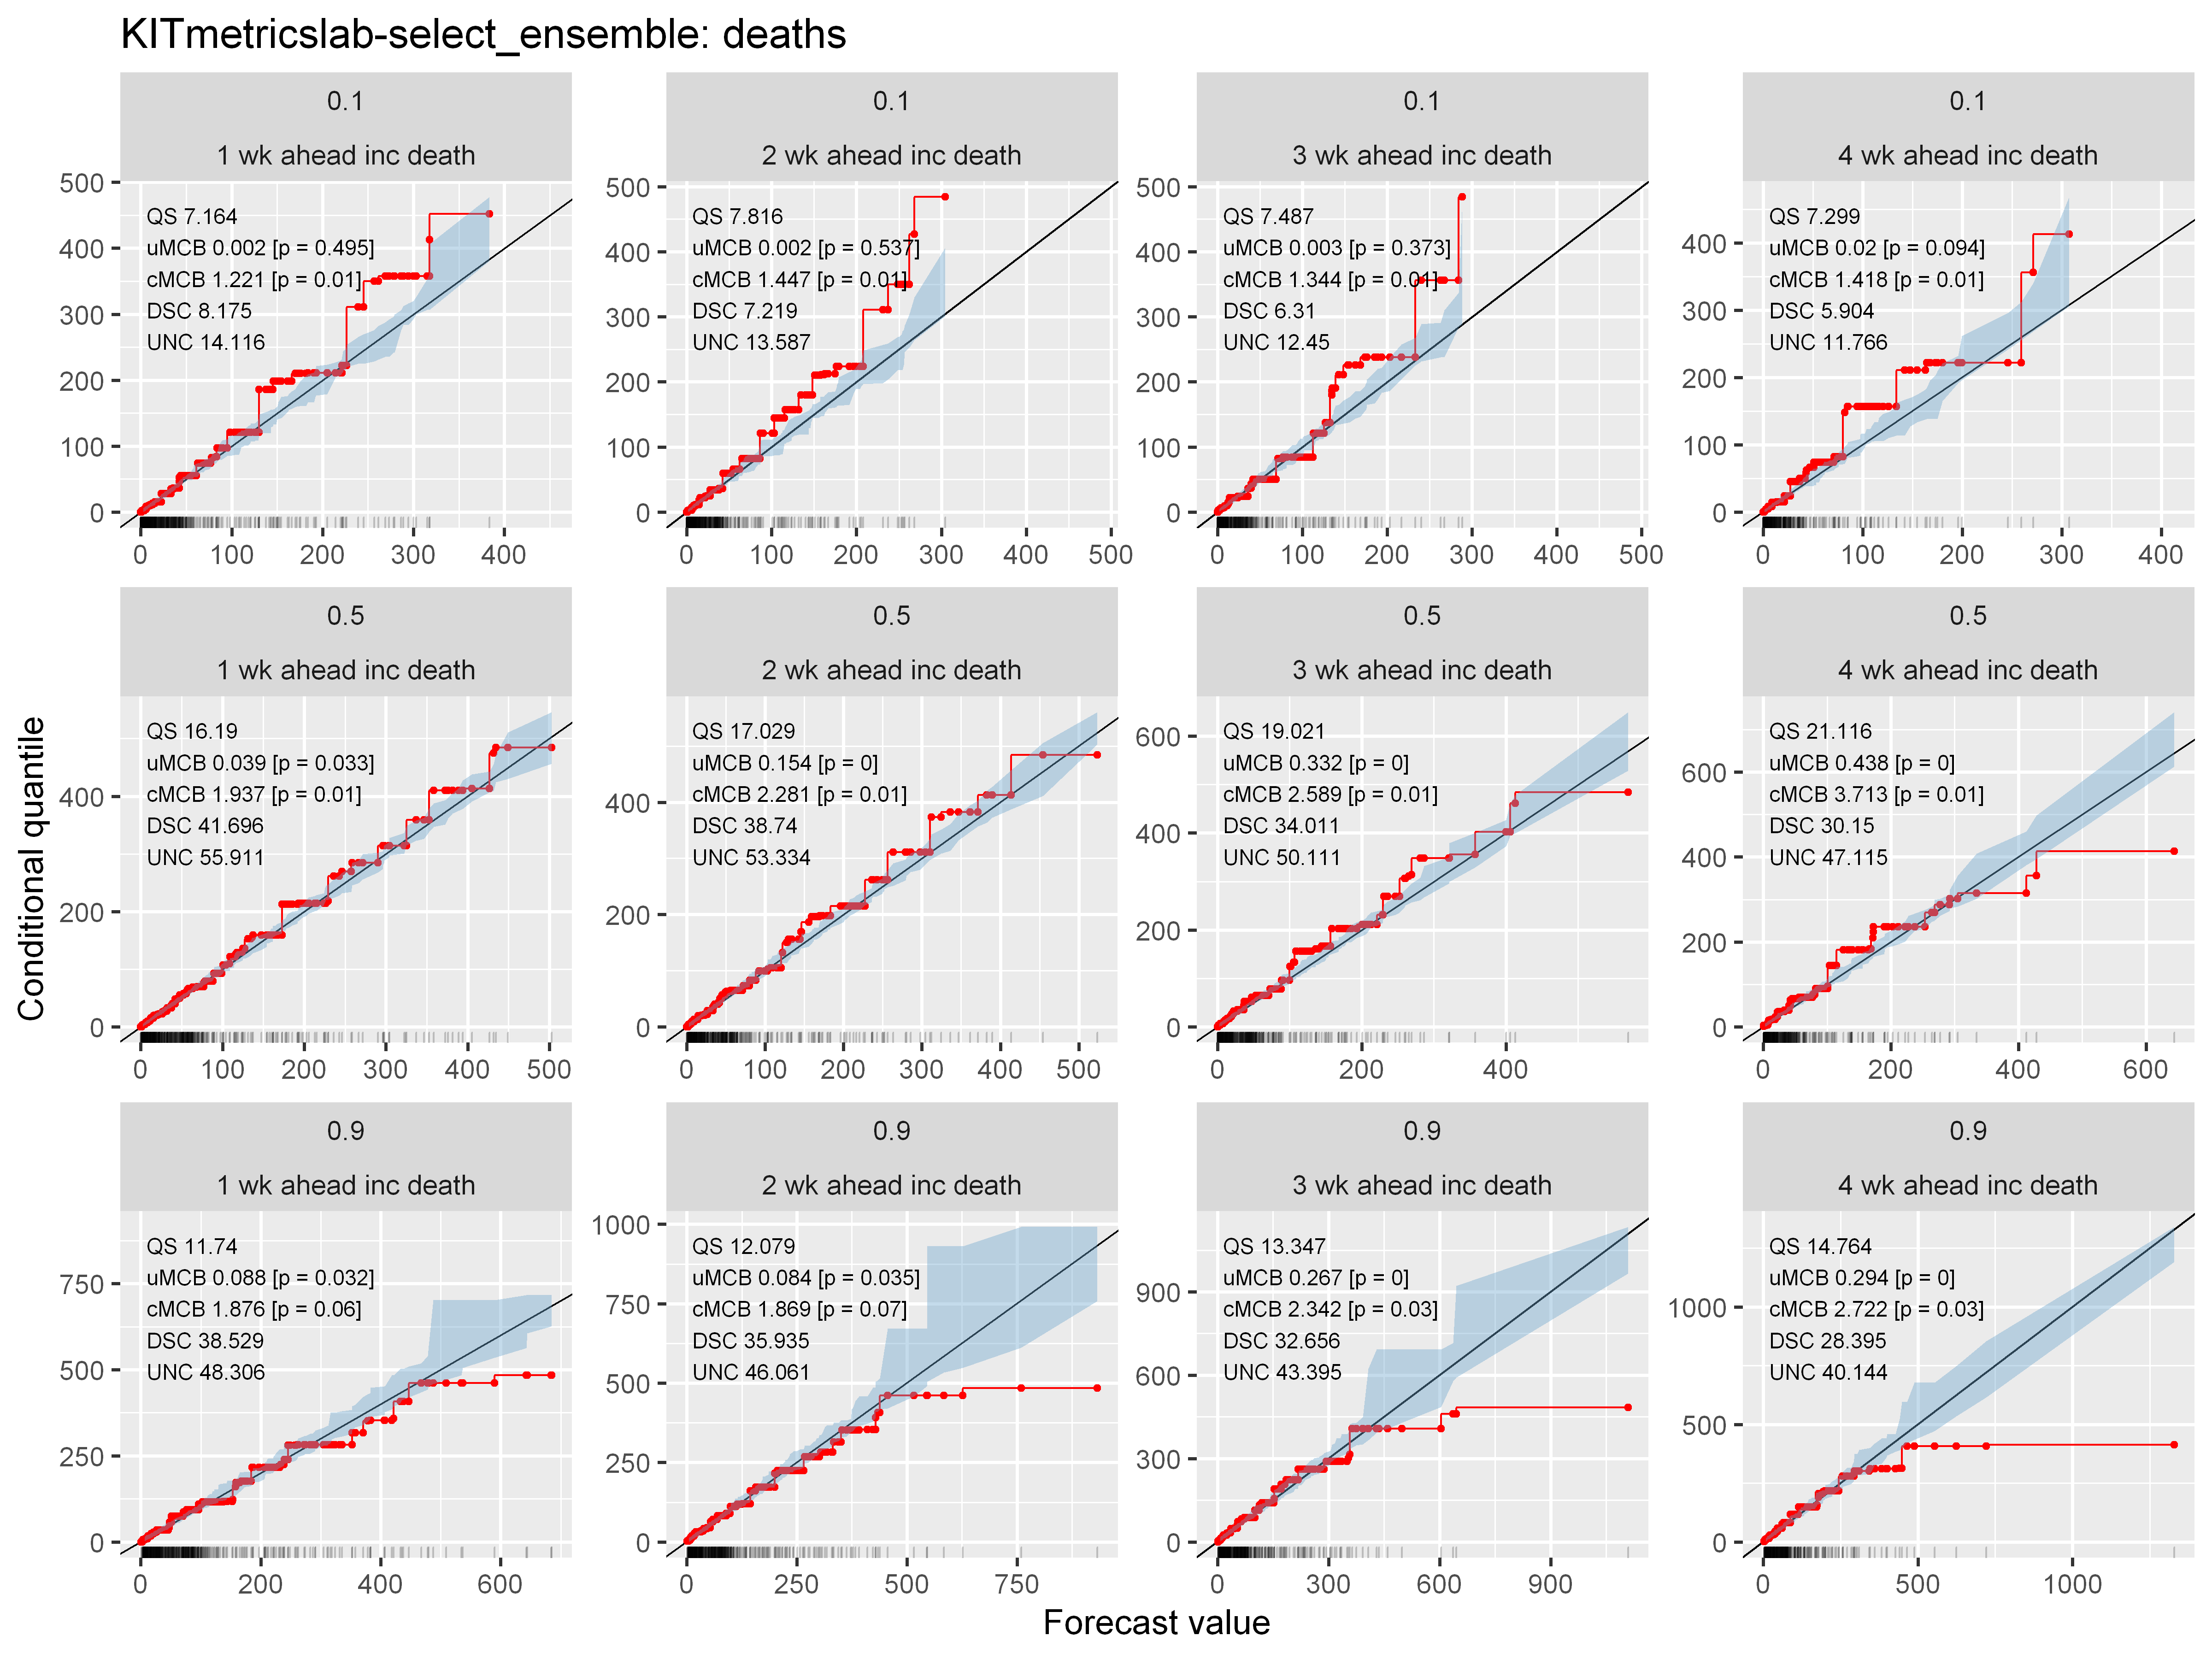

In [42]:
reliability_diagram_all(df, "KITmetricslab-select_ensemble", "death", c(0.1, 0.5, 0.9), n_resamples = 99)

# Forecasts

Shown are national level median forecasts (white dots) together with 50% and 95% prediciton intervals. The observed values are shown in black.

In [43]:
df <- read_csv(paste0("evaluation/", eval_date, "_df_processed.csv"), col_types = cols())
df <- pivot_wider(df, names_from=quantile, names_prefix="value.", values_from=value)

In [44]:
cols <- colorRampPalette(c("deepskyblue4", "lightgrey"))(2 + 1)[-1]

In [45]:
options(repr.plot.width=12, repr.plot.height=12, repr.plot.res = 300)

In [46]:
df_ens <- df %>%
filter(model == "KITmetricslab-select_ensemble",
      location == "US")

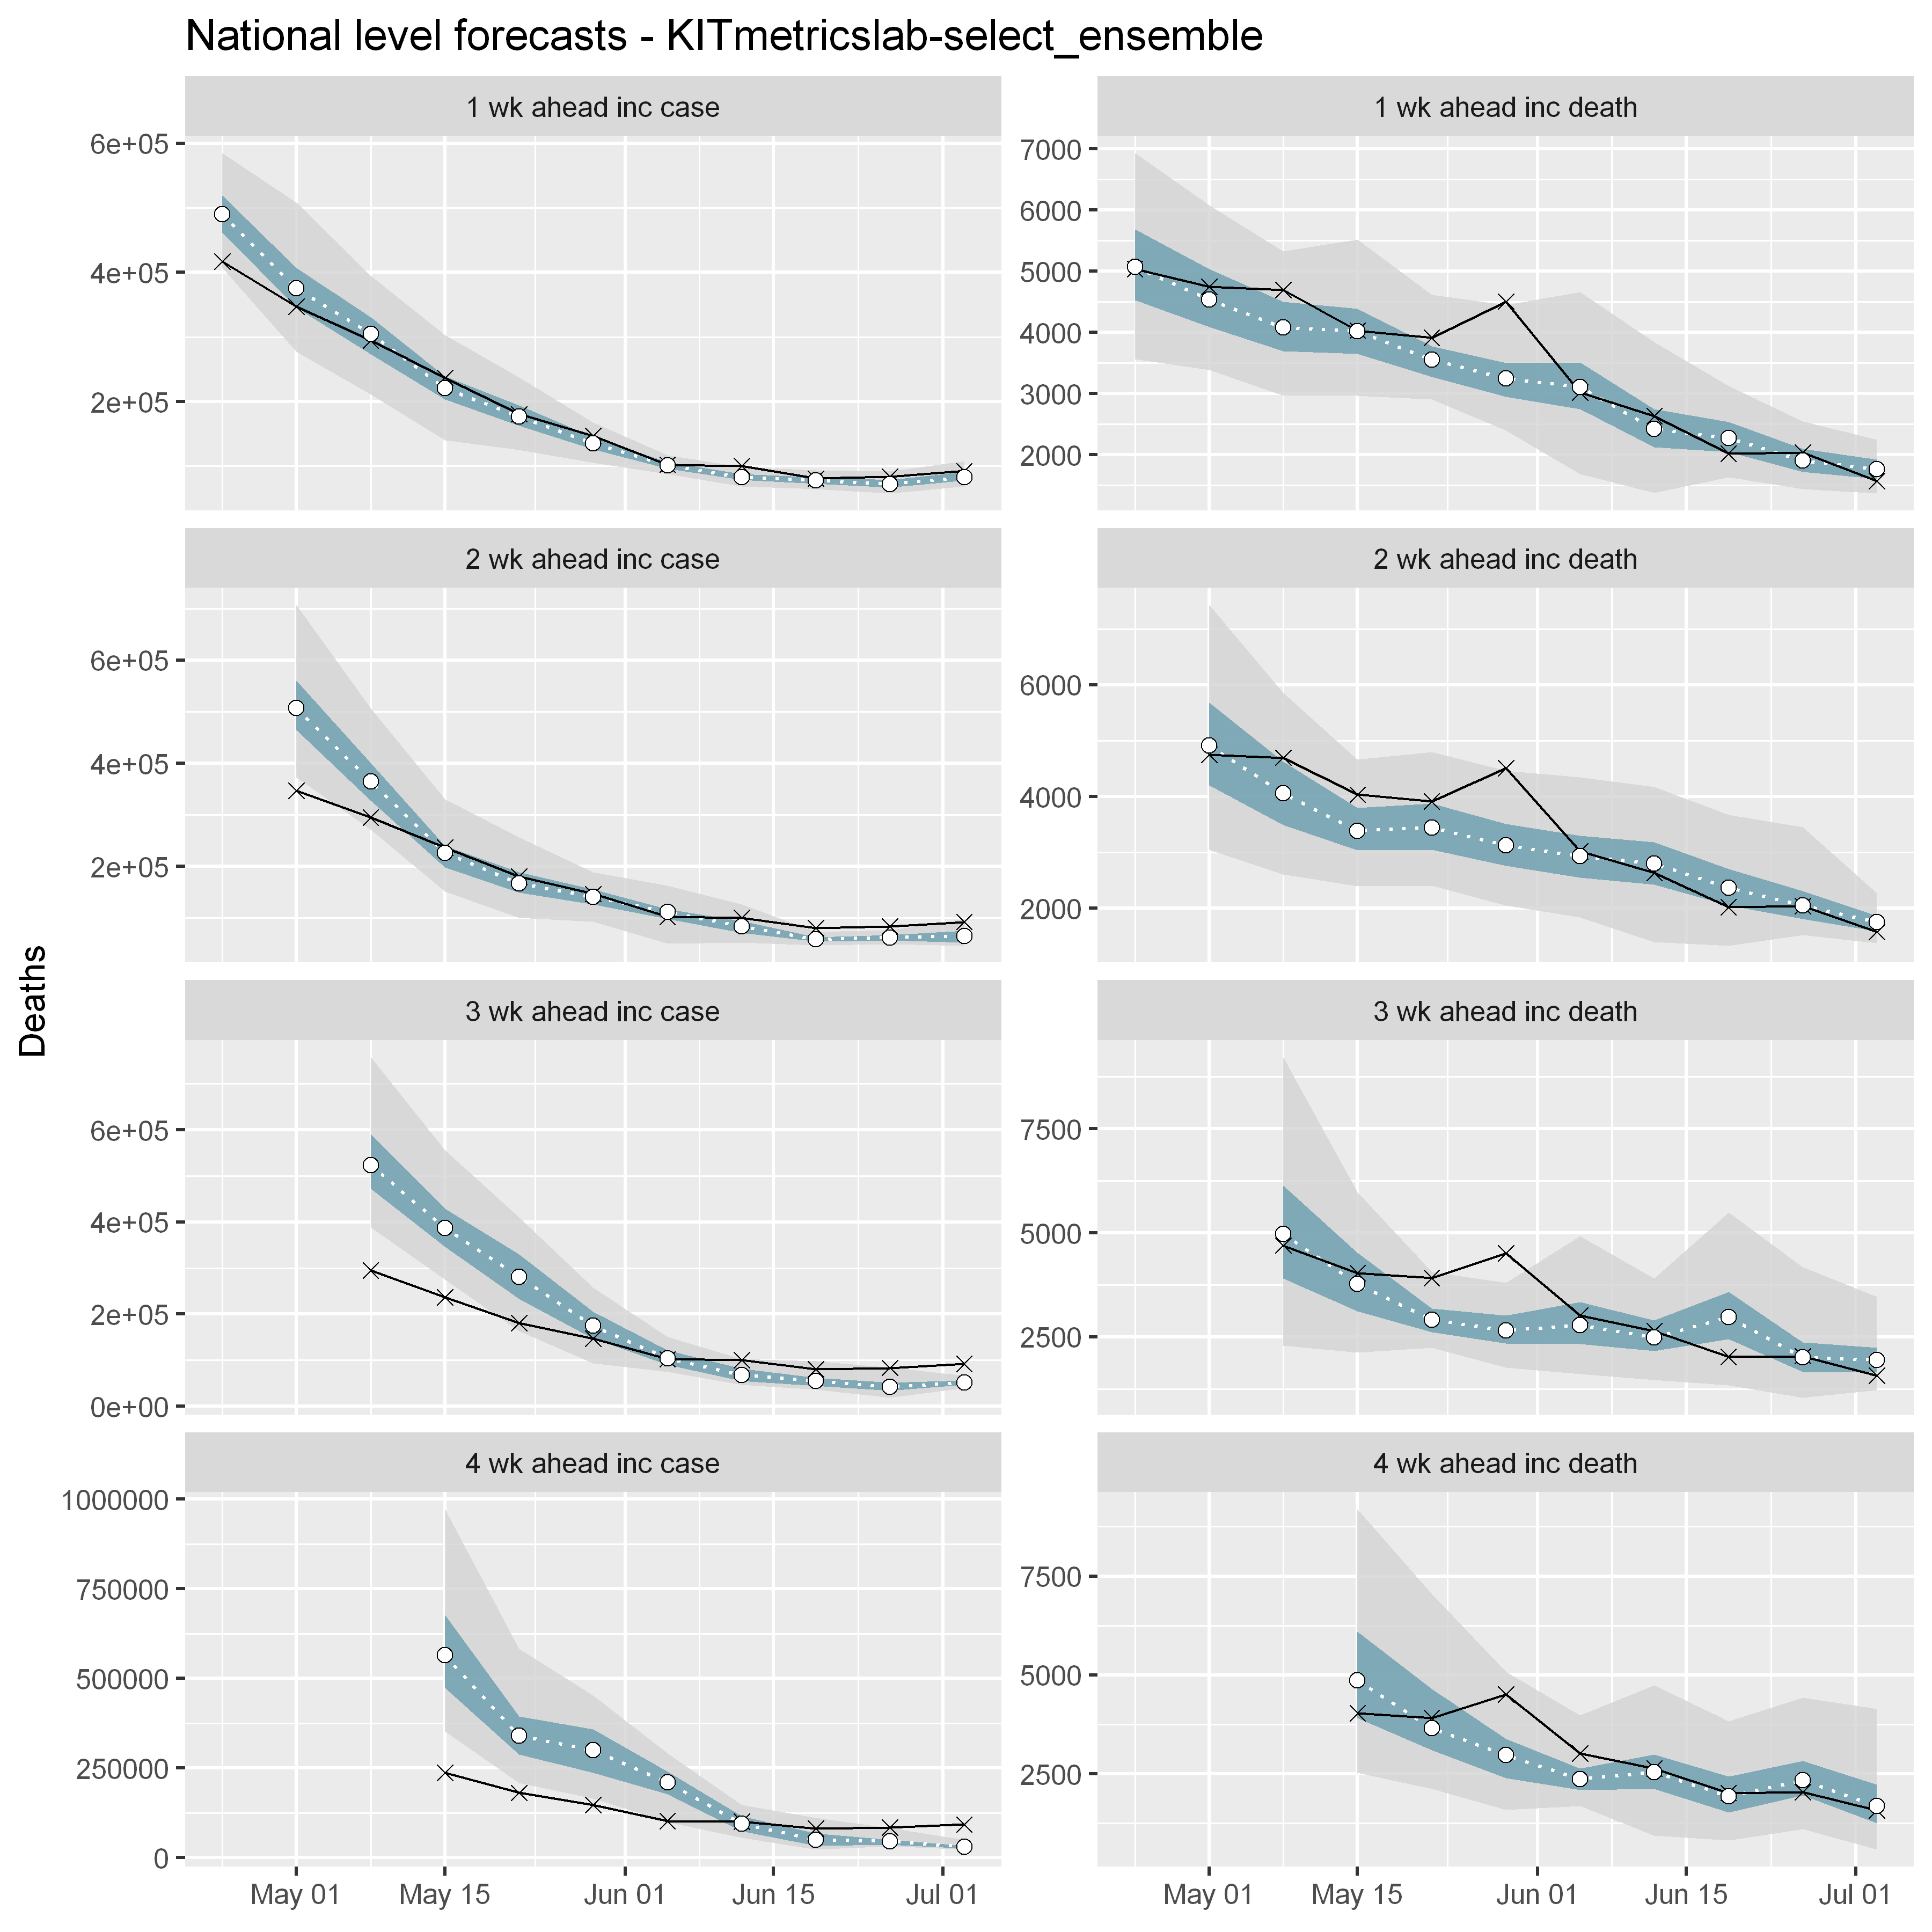

In [47]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - KITmetricslab-select_ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))

In [48]:
df_ens <- df %>%
filter(model == "COVIDhub-ensemble",
      location == "US")

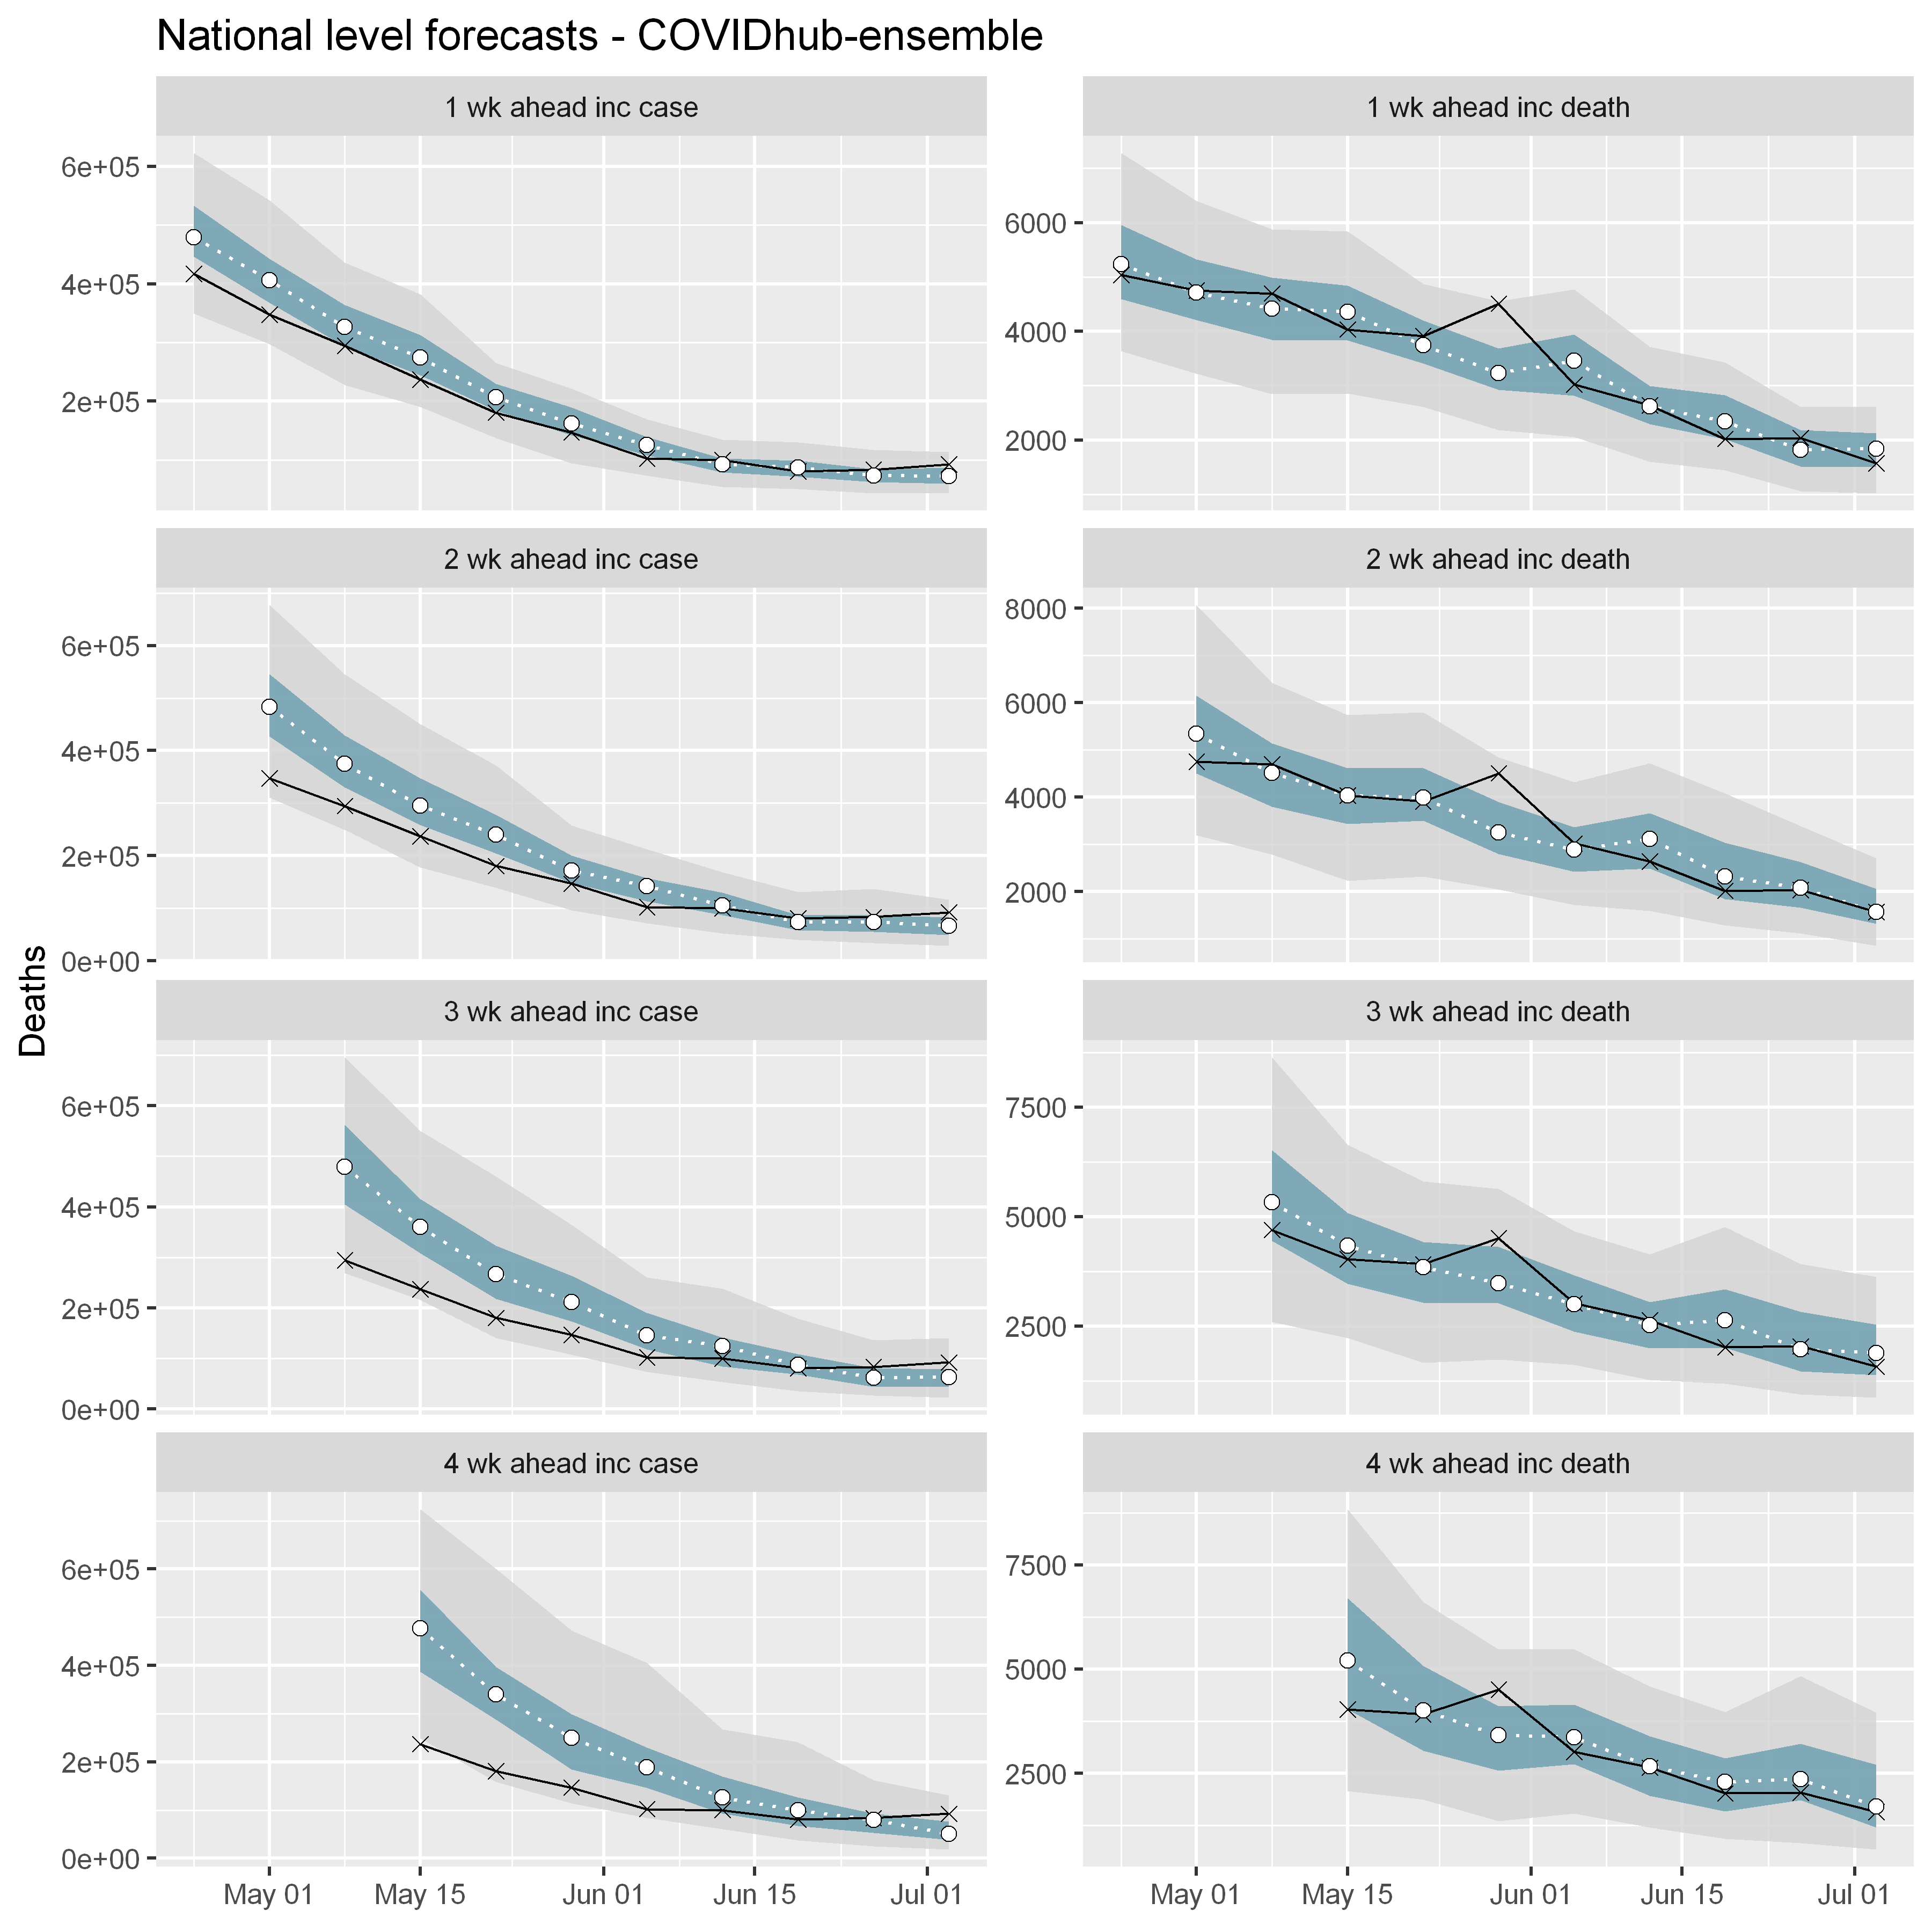

In [49]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.7, colour="white", fill=cols[2], alpha=0.8, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.7, colour="white", fill=cols[1], alpha=0.8, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=3) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=3) +
  theme_bw() +
  labs(title="National level forecasts - COVIDhub-ensemble",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))